In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import skimage as ski
from skimage import io
import skimage.transform
import pickle
import time
import skimage.filters
import os
import sklearn.model_selection
##Universal Dimension for input data:
height=128
width=128
depth=1
# Here we load the train and test data and labels
# These data initially came from Caltech 101 - http://www.vision.caltech.edu/Image_Datasets/Caltech101/
# If these .npy files are unavailable, use the load_all_data function to scan through the folders and
# auto-generate a list of categories
X_train=np.load("X_train.npy")
X_test=np.load("X_test.npy")
y_train=np.load("y_train.npy")
y_test=np.load("y_test.npy")
categories=np.load("categories.npy")
######
######
###### BEGIN FUNCTION DEFS

def load_all_data(path="/101_ObjectCategories/",resize=True):
    """Loads image files stored in folders which bear the name of their class"""
    categories=os.listdir(os.getcwd()+path)[1:]
    all_data=[]
    all_labels=[]
    for i in range(len(categories)):
        local_path=os.getcwd()+path+categories[i]+'/'
        local_data=[plt.imread(local_path+image) for image in os.listdir(local_path)]
        local_labels=[i]*len(local_data)
        all_data=all_data+local_data
        all_labels=all_labels+local_labels
    print("Done loading data")
    if resize==True:
        all_data=[ski.transform.resize(ski.color.rgb2gray(image),[height,width,depth]) for image in all_data]
        print("Done resizing images")
    return all_data,all_labels,categories

def perturb_images(image_set,mode=0):
    """This function artificially increases the data set by applying a random crop (mode 1) reflection (2), 
    gamma adjust (3), adds random noise (4), or blurs the image slightly (5)  I would not advise using mode 1, as it seems
    to not improve things"""
    if mode==0:
        output=[ski.transform.resize(image,[height,width,depth]) for image in image_set]
    elif mode==1:
        shape=image_set[0].shape
        x_seed=np.random.randint(0,shape[0]-height)
        y_seed=np.random.randint(0,shape[1]-width)
        output=[image[x_seed:x_seed+height,y_seed:y_seed+width] for image in image_set]
    elif mode==2:
        output=[image[:,::-1] for image in image_set]
    elif mode==3:
        output=[ski.exposure.adjust_gamma(image) for image in image_set]
    elif mode==4:
        output=[ski.util.random_noise(image) for image in image_set]
    elif mode==5:
        output=[ski.filters.gaussian(image) for image in image_set]
 
    else:
        print("Mode set to %s, out of range" %mode)
        return 0
    if np.shape(output[0])!=(height,width,depth):
        output=[ski.transform.resize(image,[height,width,depth]) for image in output]
    return output

def classify(input_image):
    """Perform the basic task of classification of a single novel image.  Useful for parties"""
    if np.shape(input_image)!=(height,width,depth):
        image=transform.resize(input_image,(height,width,depth))
        print("Transformed")
    else:
        image=input_image
    X=sess.run([logits], feed_dict={x: (np.reshape(image,[1,height,width,depth])), y: (np.reshape(0,[1,]))})
    ps = np.exp(X * 1)
    ps /= np.sum(ps)
    plt.figure(figsize=[10,5])
    print(ps)
    plt.bar(np.arange(len(categories)),ps[0][0])
    
    plt.xticks(np.arange(len(categories)),categories)
    #plt.title("%s percent sure" %np.round(100*np.max(ps[0]),1))
    plt.show()
    io.imshow(input_image)

    plt.show()

def get_batch(features,labels,batch_size):
    """Selects a training batch from the total set"""
    feature_length=len(features)
    output_features=[]
    output_labels=[]
    for i in range(batch_size):
        element_id=np.random.randint(0,feature_length)
        output_features.append(features[element_id])
        output_labels.append(labels[element_id])
    return output_features,output_labels

def generate_batch_type(index,batch_size=200,test_images=X_test,test_labels=y_test):
    """Generates a batch of examples which share a label"""
    output_images=[]
    for i in range(len(test_images)):
        if test_labels[i]==index:
            output_images.append(test_images[i])
        if len(output_images)==batch_size:
            break
    output_labels=[index]*len(output_images)
    return output_images, output_labels

def detailed_accuracy_report():
    """Compute the accuracy of the classifier broken down by category.
    Not implemented for an arbitrary number of classes, this version accomodates 10"""
    a_list=[]
    for i in range(len(categories)):
        b0,l0=generate_batch_type(i,batch_size=800)
        b0=perturb_images(b0)
        X=sess.run(accuracy, feed_dict={x: b0, y:l0})
        a_list.append(X)
    plt.figure(figsize=[10,5])
    plt.bar(np.arange(len(categories)),a_list)
    plt.xticks(np.arange(len(categories)),categories)
    plt.show()



###Make saliency fcts work in general
def plot_saliency(input_image):
    """Compute the plots of saliency across 10 categories.  Similar to guided backpropagation.
     Not implemented for an arbitrary number of classes, this version accomodates 10"""
    io.imshow(input_image)
    plt.show()
    graders=[tf.gradients(logits[0][i],x) for i in range(10)]
    logs, saliency=sess.run([logits,graders], feed_dict={x: [input_image], y: [1],mode:"test"})
    fig, axes = plt.subplots(ncols=5,nrows=2, figsize=(20,10))
    ax = axes.ravel()
    for i in range(10):
        image=ski.color.rgb2gray(saliency[i][0][0])
        thresh = ski.filters.threshold_mean(image)
        binary = image > thresh
        image=image*binary
        ax[i].imshow(image)
        ax[i].set_xlabel("Activation gradients for "+str(categories[i]))
        ax[i].set_ylabel("logit was "+str(logs[0][i]))

    plt.show()

def plot_max_saliency(input_image):
    """Will plot the saliency (guided backprop image) for the most likely category
    Currently not implemented for this project"""
    graders=[tf.gradients(logits[0][i],x) for i in range(10)]
    logs, saliency=sess.run([logits,graders], feed_dict={x: [input_image], y: [1],mode:"test"})
    fig, axes = plt.subplots(ncols=2,nrows=1, figsize=(20,10))
    ax = axes.ravel()
    i=np.argmax(logs)
    image=ski.color.rgb2gray(saliency[i][0][0])
    thresh = ski.filters.threshold_mean(image)
    binary = image > thresh
    image=image*binary
    ax[0].imshow(input_image)
    ax[1].imshow(image)
    ax[1].set_xlabel("Activation gradients for "+str(categories[i]))
    ax[1].set_ylabel("logit was "+str(logs[0][i]))

    plt.show()
def push_py_to_cloud():
    """Simple fct to take a py file saved locally and load it into its correct place in the cloud"""
    !gcloud compute scp ~/Downloads/"101_Class.py" instance-2:~/"101_Class" --zone us-central1-c
def update_from_cloud():
    """Loads all model data from its location on the cloud to a local repository"""
    !gcloud compute scp instance-2:~/101_Class/t*.npy ~/101_Class --zone us-central1-c
    !gcloud compute scp instance-2:~/101_Class/checkpoint ~/101_Class --zone us-central1-c
    !gcloud compute scp instance-2:~/101_Class/101_Class.meta ~/101_Class --zone us-central1-c
    !gcloud compute scp instance-2:~/101_Class/101_Class.index ~/101_Class --zone us-central1-c
    !gcloud compute scp instance-2:~/101_Class/101_Class.data* ~/101_Class/ --zone us-central1-c
def check_on_cloud(reload=True):
    """Loads and plots just the small npy files used to monitor the progress of learning"""
    if reload==True:
        !gcloud compute scp instance-2:~/101_Class/t*.npy ~/101_Class --zone us-central1-c
    train_acc_list=np.load("train_acc_list.npy")
    test_acc_list=np.load("test_acc_list.npy")

    plt.figure(figsize=[10,5])
    plt.title((np.max(test_acc_list)))
    plt.plot(test_acc_list)
    plt.semilogx(train_acc_list)
    plt.plot(np.arange(len(train_acc_list)),[np.max(test_acc_list)]*len(train_acc_list),'r-')
    plt.ylim([0,1])
    plt.show()
def pretty_out(input_image):
    """Generates a nice summary for a single input image, including bar graphs of the final probablities
    and a saliency plot of the most likely category"""
    if np.shape(input_image)!=(height,width,depth):
        input_image=ski.transform.resize(input_image,(height,width,depth))
        print("Transformed")
    logs=sess.run([logits], feed_dict={x: [input_image], y: [1],mode:"test"})
    fig, axes = plt.subplots(ncols=2,nrows=1, figsize=(12,5), gridspec_kw = {'width_ratios':[1, 1]})
    ax = axes.ravel()
    i=np.argmax(logs)
    graders=[tf.gradients(logits[0][i],x)]
    saliency=sess.run([graders], feed_dict={x: [input_image], y: [1],mode:"test"})
    image=(saliency[0][0][0])
    thresh = ski.filters.threshold_mean(image)
    binary = image > thresh
    thresh_2 = ski.filters.threshold_mean(input_image)
    binary_2 = input_image > thresh_2
    image=(image*binary*binary_2)[0]
    ax[0].imshow(input_image.reshape([height,width]),cmap=plt.cm.gray)
    ax[1].imshow(image.reshape([height,width]),cmap=plt.cm.gray)
    ax[1].set_xlabel("Activation gradients for "+str(categories[i]))
    ax[1].set_ylabel("logit was "+str(logs[0][0][i]))
    plt.show()
    ps = np.exp(logs[0][0] * 1)
    ps /= np.sum(ps)
    plt.figure(figsize=[6,2.5])
    sorted_ps=np.argsort(ps)[::-1]
    print("Top matches are: ")
    top_cats,top_ps=[],[]
    for i in range(5):
        index=sorted_ps[i]
        print(categories[index]+"  -  "+str(ps[index]))
        top_cats.append(categories[index])
        top_ps.append(ps[index])
    plt.bar(np.arange(len(top_cats)),top_ps)
    plt.xticks(np.arange(len(top_cats)),top_cats)
    plt.show()


In [7]:
tf.reset_default_graph()
#
#Here we set up our network.  The best results I was able to obtain were from the architecture:
# 128x128x1 input --> 5x5x16 convolution layer (1)--> 2x2 maxpool layer (1) -> 5x5x32 convolution layer (2) ->  2x2 maxpool layer  (2)
# - >  5x5x32 convolution layer (3) ->  2x2 maxpool layer  (3)
# - > 1024 fully connected layer (relu with dropout) -> 101 logits with softmax
# Obviously many other setups are possible, and this code can be changed with a couple keystrokes to add
# another fully connected layer with dropout or another conv-pool set of layers.
# For this problem, due to data scarcity, these additional layers did not contribute positively to the final result
# If training for a long time, however, using the dropout layer was seen to combat overfitting
#
#
# x is the input, y is the output
x = tf.placeholder(dtype = tf.float32, shape = [None, height, width, depth],name="x_name")
y = tf.placeholder(dtype = tf.int32, shape = [None],name="y_name")
mode = tf.placeholder(dtype = tf.string, shape = (),name="mode_name")
# Setting this mode is important so that learning and dropout may commmence
# The layer structure is described above, implemented here:
input_layer=x
##currently the stack is 128 x 128 = 2**14
conv1=tf.layers.conv2d(inputs=input_layer,filters=16,kernel_size=[5,5],padding="same",activation=tf.nn.relu)
## - > 128 * 128 * 16 = 262144 activations 
pool1=tf.layers.max_pooling2d(inputs=conv1,pool_size=[2,2],strides=2)
## - > 64 * 64 *16 = 65536
conv2=tf.layers.conv2d(inputs=pool1,filters=32,kernel_size=[5,5],padding="same",activation=tf.nn.relu)
## - > 64 * 64 * 32 = 131072
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
## - > 32 * 32 * 32 = 32768

pool2_flat = tf.reshape(pool2,[-1,32768])

dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
dropout=tf.layers.dropout(inputs=dense,rate=0.1,training=(mode=="train"))
logits=tf.layers.dense(inputs=dropout,units=101,name="Willy_P")
#
# The cost function is the standard cross entropy with logits, training stekp is done by AdamOptimizer
Loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, logits = logits),name="Loss")
train_op = tf.train.AdamOptimizer(learning_rate=0.00005,name="train_op").minimize(Loss)
correct_pred = tf.argmax(logits, 1,name='cp')
accuracy = tf.reduce_mean(tf.cast(tf.equal(correct_pred,tf.cast(y,tf.int64)),tf.float64),name="accuracy")


(1, 16, 16, 32) 8192


In [18]:
#
#Below is the code which instantiates the session and performs the training
#A new batch of training data of size "batch_size" will be selected every epoch for "n_epochs" epochs
#
#
st=time.time()
reset_image=False #If true, the input images will be reread from disk
reset_sess=True   #If true, session is reinstantiated and all learned parameters will be discarded
restore_from_backup=True #restore a set of saved parameters
run_train=False       #if true training will commence
save=False
batch_size=1 #sets the number of samples to be considered during each epoch
n_epochs=1        #sets the number of epochs for which the training will run
if reset_image==True:
    ### If instantiating without the .npy files, uncomment the next two lines to generate new data from folders
    #all_data,all_labels,categories=load_all_data()
    #X_train, X_test, y_train, y_test=sklearn.model_selection.train_test_split(all_data,all_labels,test_size=0.1)
    X_train=np.load("X_train.npy")
    X_test=np.load("X_test.npy")
    y_train=np.load("y_train.npy")
    y_test=np.load("y_test.npy")
    categories=np.load("categories.npy")
if reset_sess==True:
    tf.set_random_seed(14)
    sess = tf.Session()
    loss_list=[]      #We track the loss and accuracy during training 
    train_acc_list=[]
    test_acc_list=[]
    sess.run(tf.global_variables_initializer())
if restore_from_backup==True:
    ## In this section we load the entire graph from stored values.  For other functions defined above to operate,
    ## it is necessary to load many variables by name
    ## We also load in *_list.npy to allow long term monitoring of the training
    tf.reset_default_graph()
    sess=tf.Session()   
    saver = tf.train.import_meta_graph('101_Class.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    graph = tf.get_default_graph()
    x = graph.get_tensor_by_name("x_name:0")
    y = graph.get_tensor_by_name("y_name:0")
    accuracy=graph.get_tensor_by_name("accuracy:0")
    train_op = graph.get_operation_by_name("train_op")
    logits = graph.get_tensor_by_name("Willy_P/BiasAdd:0")
    correct_p=graph.get_tensor_by_name("cp:0")
    mode = graph.get_tensor_by_name("mode_name:0")
    Loss = graph.get_tensor_by_name("Loss:0")
    loss_list=list(np.load("loss_list.npy"))
    train_acc_list=list(np.load("train_acc_list.npy"))
    test_acc_list=list(np.load("test_acc_list.npy"))

    print("Model restored.")
if run_train==True:
    for i in range(n_epochs):
            print('EPOCH', i)

            batch_features,batch_labels = get_batch(X_train,y_train,batch_size)
            batch_features=perturb_images(batch_features,mode=np.random.randint(2,6))
            _, train_acc,loss = sess.run([train_op, accuracy,Loss], feed_dict={x: batch_features, y: batch_labels,mode:"train"})
            if i % 5 == 0:
                loss_list.append(loss)
                train_acc_list.append(train_acc)

                test_batch_features,test_batch_labels = get_batch(X_test,y_test,batch_size)
                test_batch_features=perturb_images(test_batch_features)
                test_acc=sess.run([accuracy], feed_dict={x: test_batch_features, y: test_batch_labels,mode:"test"})
                test_acc_list.append(test_acc)
                print("test_acc=%s"%test_acc)
                print("Time since start=%s"%(time.time()-st))
            if save==True and i%10==0:
                saver = tf.train.Saver()
                saver.save(sess, '101_Class')
                print("Model Saved")
                np.save("loss_list",loss_list)
                np.save("train_acc_list",train_acc_list)
                np.save("test_acc_list",test_acc_list)



INFO:tensorflow:Restoring parameters from ./101_Class
Model restored.


test_acc_list.npy                             100% 3560     3.5KB/s   00:00    
train_acc_list.npy                            100% 3560     3.5KB/s   00:01    


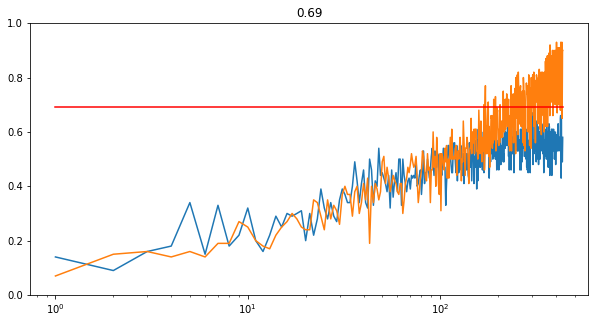

In [127]:

check_on_cloud(reload=True)
#push_py_to_cloud()
#update_from_cloud()

In [34]:
update_from_cloud()

test_acc_list.npy                             100% 2680     2.6KB/s   00:00    
train_acc_list.npy                            100% 2680     2.6KB/s   00:00    
checkpoint                                    100%   75     0.1KB/s   00:00    
101_Class.meta                                100% 3098KB 281.7KB/s   00:11    
101_Class.index                               100% 1065     1.0KB/s   00:01    
101_Class.data-00000-of-00001                 100%  385MB   3.2MB/s   02:01    


Top matches are: 
airplanes  -  0.109026
Faces_easy  -  0.101884
Faces  -  0.0723529
watch  -  0.0375315
bonsai  -  0.018122


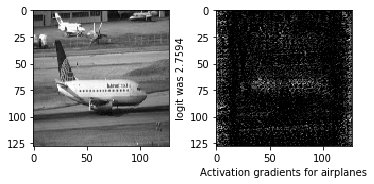

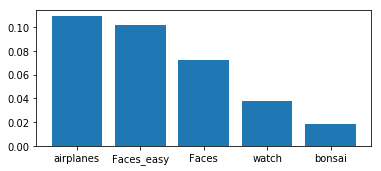

In [16]:
ii+=1
image1=X_test[ii]
pretty_out(image1)

In [35]:
a1=[1,2,3,0,1]
np.argsort(a1)

array([3, 0, 4, 1, 2])

In [65]:
#!gcloud compute scp  ~/"101_Class"/categories.npy instance-2:~/"101_Class" --zone us-central1-c

categories.npy                                100% 6140     6.0KB/s   00:00    


In [28]:
len(categories)

101

In [131]:
test_batch_features,test_batch_labels = get_batch(X_test,y_test,100)
test_batch_features=perturb_images(test_batch_features)
               
test_acc=sess.run([accuracy], feed_dict={x: test_batch_features, y: test_batch_labels,mode:"test"})
test_acc

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[0.54000000000000004]

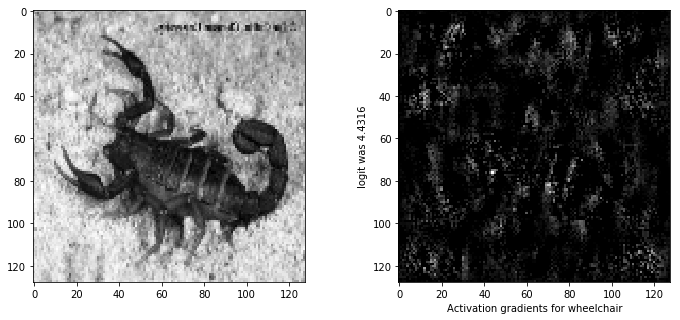

Top matches are: 
wheelchair  -  0.146713
lobster  -  0.102813
grand_piano  -  0.0632734
hedgehog  -  0.0612578
cup  -  0.0457495


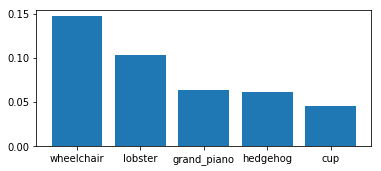

correct class is scorpion
--------------------------


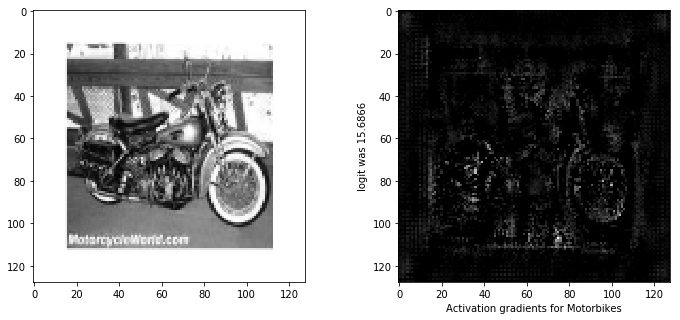

Top matches are: 
Motorbikes  -  0.999236
pizza  -  0.00017641
cup  -  8.83197e-05
hedgehog  -  7.3913e-05
camera  -  5.61992e-05


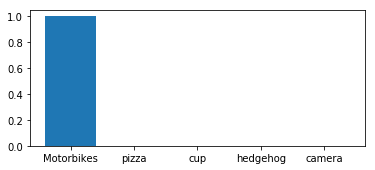

correct class is Motorbikes
--------------------------


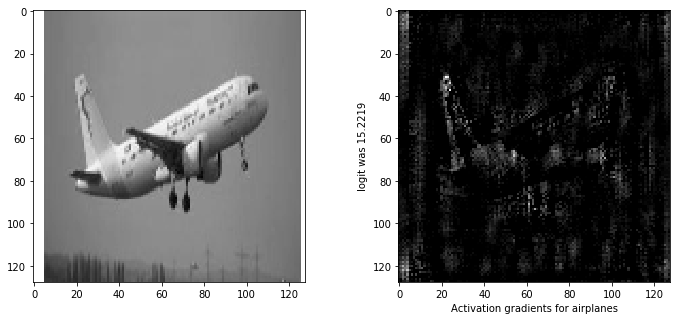

Top matches are: 
airplanes  -  0.999474
electric_guitar  -  0.000282045
mandolin  -  7.04754e-05
mayfly  -  3.12293e-05
Motorbikes  -  1.89758e-05


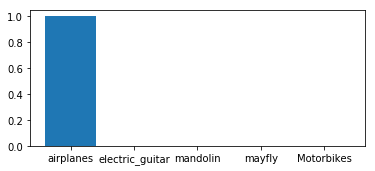

correct class is airplanes
--------------------------


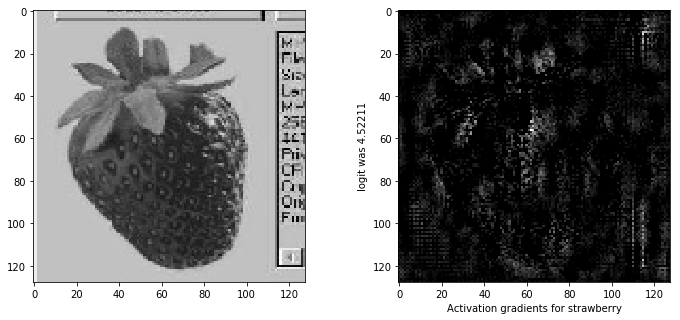

Top matches are: 
strawberry  -  0.14952
elephant  -  0.115966
cup  -  0.06299
ewer  -  0.0617683
beaver  -  0.0453568


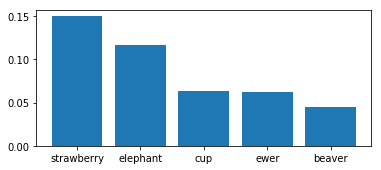

correct class is strawberry
--------------------------


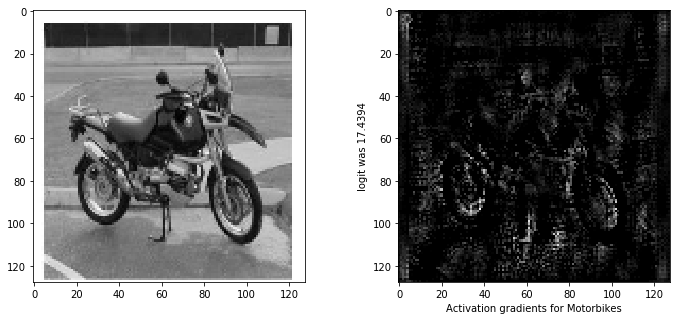

Top matches are: 
Motorbikes  -  0.999809
wheelchair  -  9.15776e-05
chandelier  -  6.16737e-05
chair  -  8.14105e-06
laptop  -  6.13708e-06


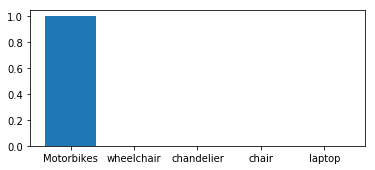

correct class is Motorbikes
--------------------------


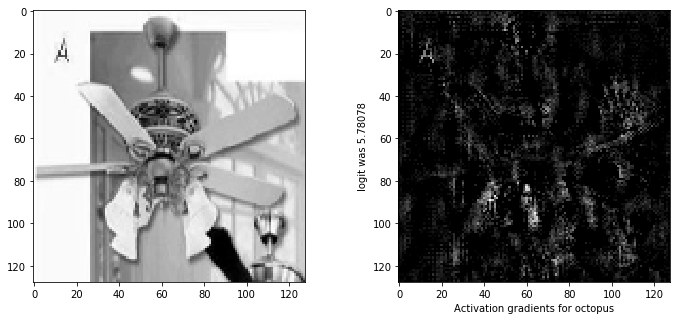

Top matches are: 
octopus  -  0.189128
scissors  -  0.149905
nautilus  -  0.149464
sunflower  -  0.100248
starfish  -  0.0432408


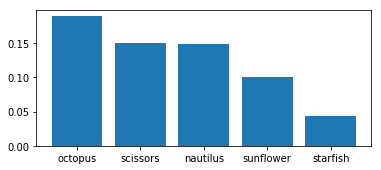

correct class is ceiling_fan
--------------------------


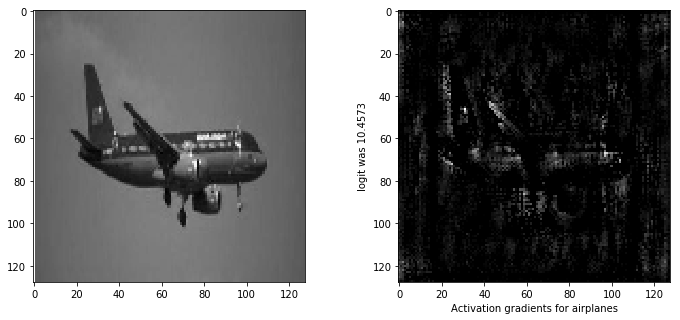

Top matches are: 
airplanes  -  0.991244
mayfly  -  0.000695134
electric_guitar  -  0.000592583
dragonfly  -  0.000484755
ant  -  0.000439731


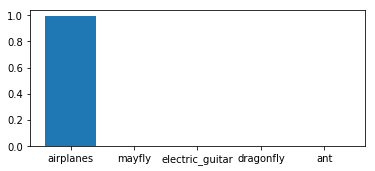

correct class is airplanes
--------------------------


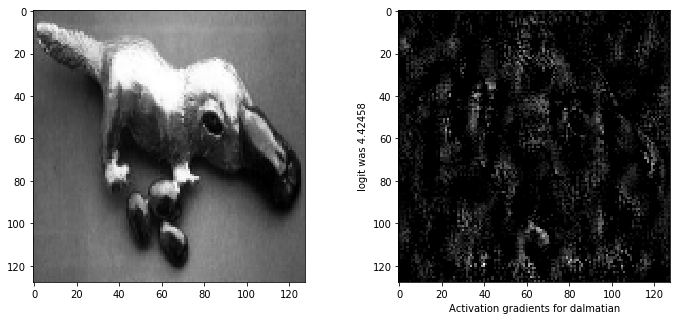

Top matches are: 
dalmatian  -  0.107668
menorah  -  0.100781
emu  -  0.0972584
flamingo  -  0.0824558
rooster  -  0.0766876


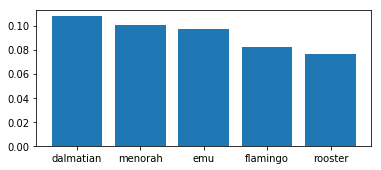

correct class is platypus
--------------------------


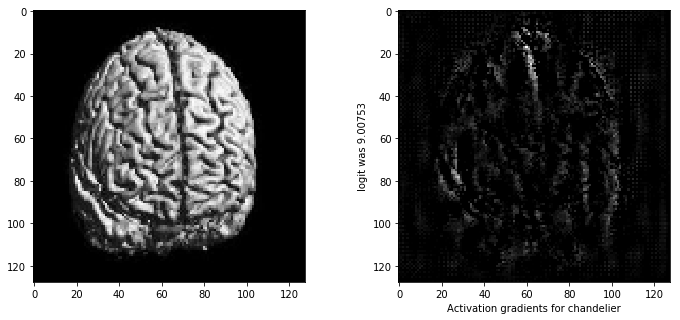

Top matches are: 
chandelier  -  0.630373
brain  -  0.237485
nautilus  -  0.0251453
watch  -  0.0217117
bonsai  -  0.0135368


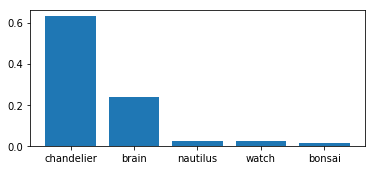

correct class is brain
--------------------------


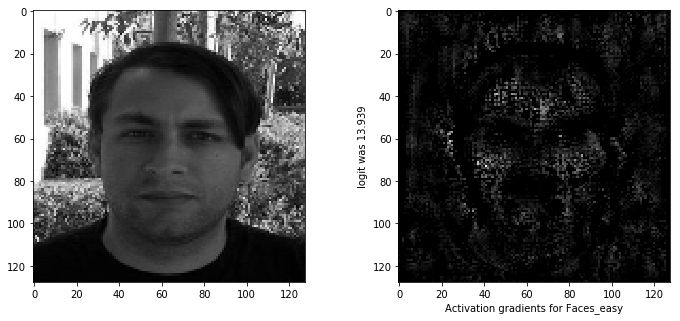

Top matches are: 
Faces_easy  -  0.999073
barrel  -  0.000182336
anchor  -  0.000149441
laptop  -  8.35338e-05
crab  -  8.02654e-05


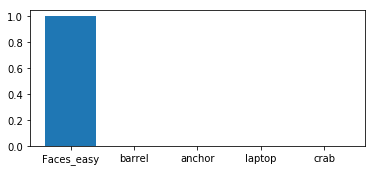

correct class is Faces_easy
--------------------------


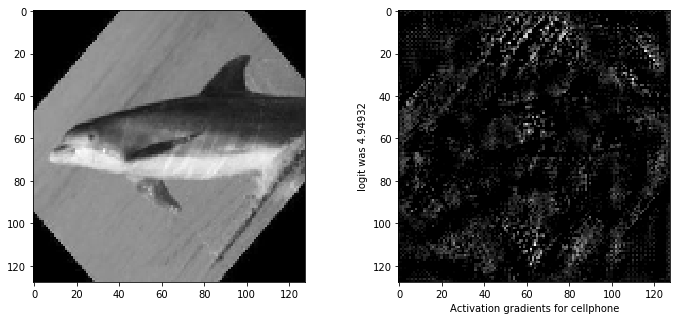

Top matches are: 
cellphone  -  0.200344
trilobite  -  0.0973582
dolphin  -  0.0945992
electric_guitar  -  0.0854864
stapler  -  0.0672794


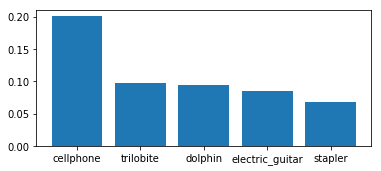

correct class is dolphin
--------------------------


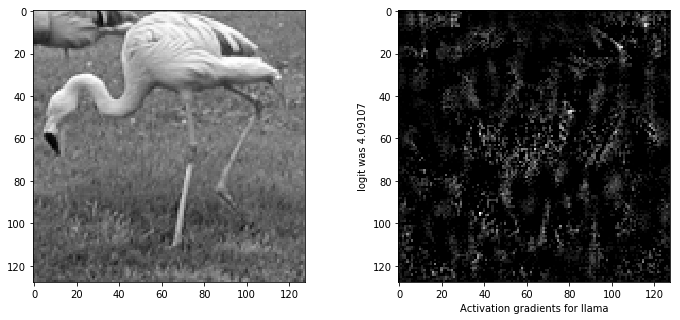

Top matches are: 
llama  -  0.155748
flamingo  -  0.127787
umbrella  -  0.106978
barrel  -  0.0503489
kangaroo  -  0.0477188


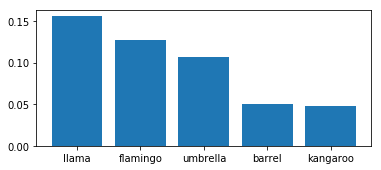

correct class is flamingo
--------------------------


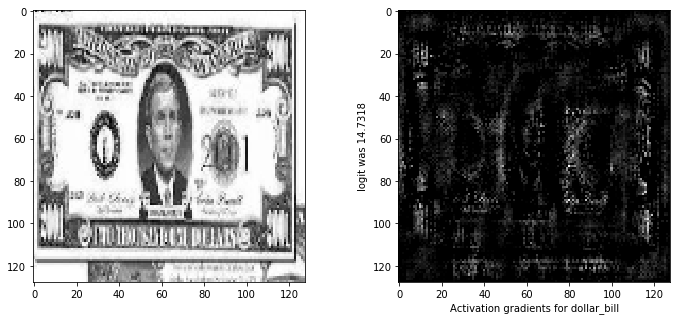

Top matches are: 
dollar_bill  -  0.99851
chandelier  -  0.000531892
llama  -  0.000324665
ketch  -  0.000175566
sea_horse  -  0.000119075


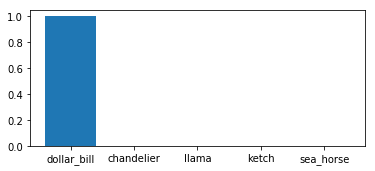

correct class is dollar_bill
--------------------------


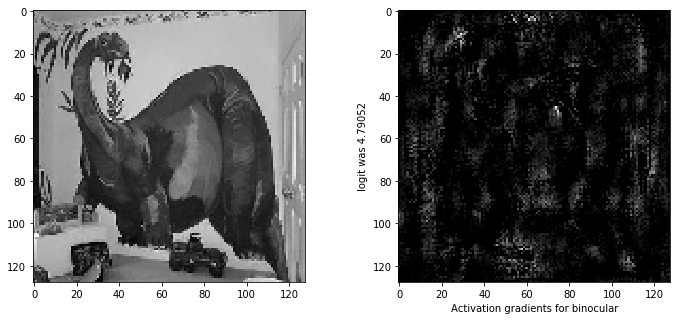

Top matches are: 
binocular  -  0.159286
hedgehog  -  0.116612
dalmatian  -  0.0993057
brontosaurus  -  0.0872051
butterfly  -  0.065094


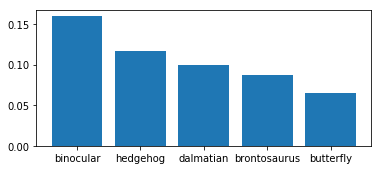

correct class is brontosaurus
--------------------------


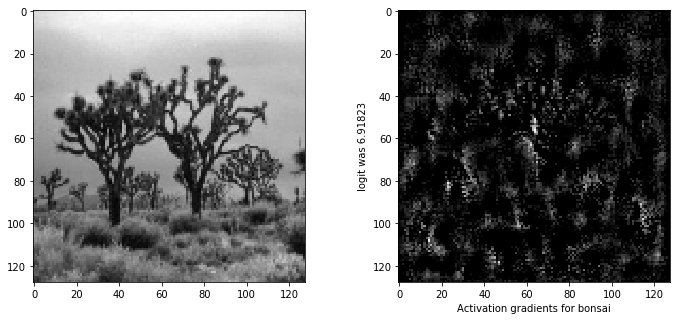

Top matches are: 
bonsai  -  0.45394
joshua_tree  -  0.244223
ferry  -  0.0363426
ant  -  0.0272329
cannon  -  0.0256818


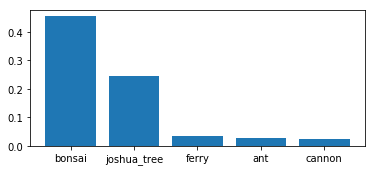

correct class is joshua_tree
--------------------------


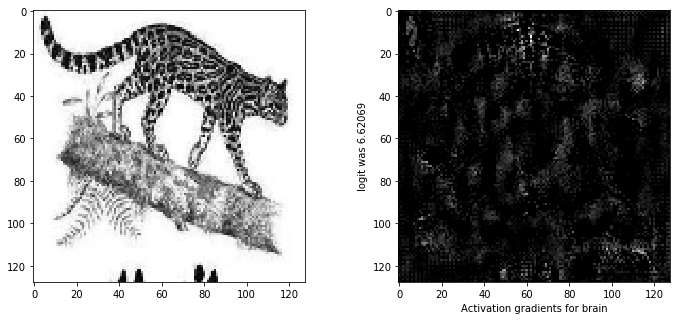

Top matches are: 
brain  -  0.224013
pizza  -  0.178244
garfield  -  0.0813538
cup  -  0.076229
hedgehog  -  0.0655195


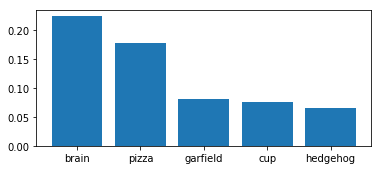

correct class is wild_cat
--------------------------


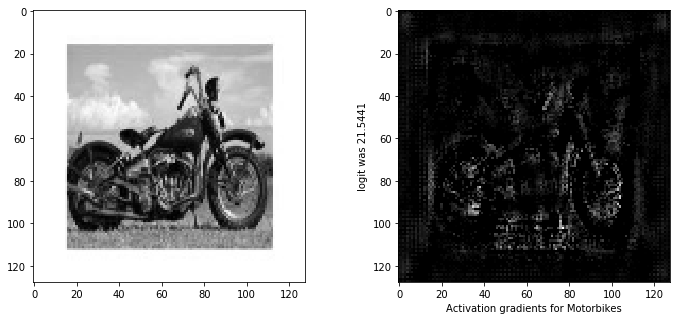

Top matches are: 
Motorbikes  -  0.999998
inline_skate  -  7.27531e-07
wheelchair  -  1.90265e-07
stapler  -  8.65074e-08
crayfish  -  6.96315e-08


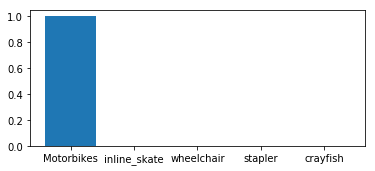

correct class is Motorbikes
--------------------------


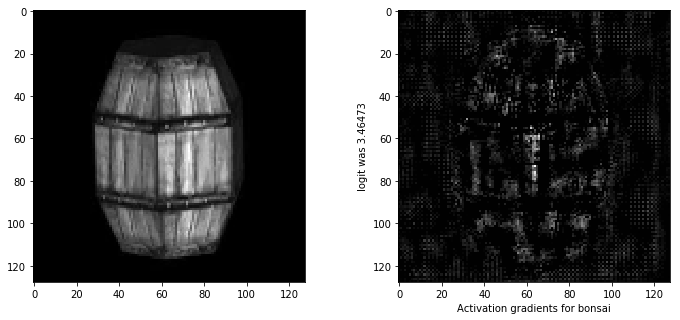

Top matches are: 
bonsai  -  0.207221
nautilus  -  0.0622675
flamingo_head  -  0.0311604
ewer  -  0.0309245
water_lilly  -  0.0305457


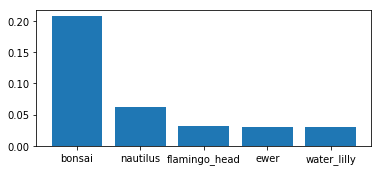

correct class is barrel
--------------------------


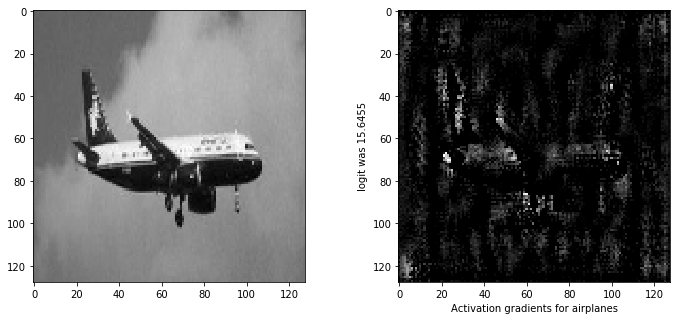

Top matches are: 
airplanes  -  0.99991
crocodile  -  1.03865e-05
electric_guitar  -  9.12274e-06
chandelier  -  7.75879e-06
mayfly  -  6.24021e-06


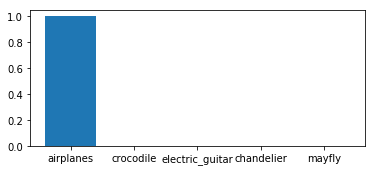

correct class is airplanes
--------------------------


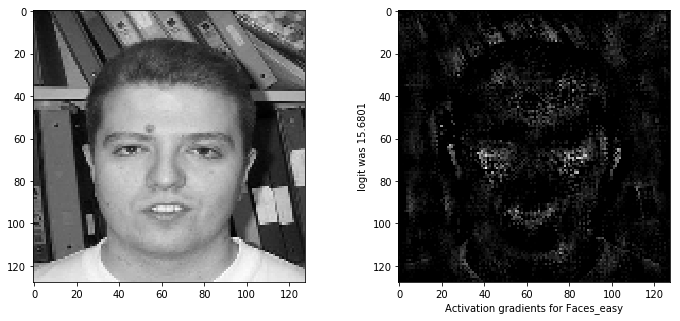

Top matches are: 
Faces_easy  -  0.999909
anchor  -  1.86352e-05
Faces  -  1.55051e-05
crocodile_head  -  8.48015e-06
rhino  -  6.66194e-06


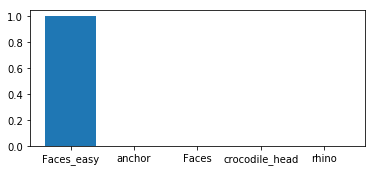

correct class is Faces_easy
--------------------------


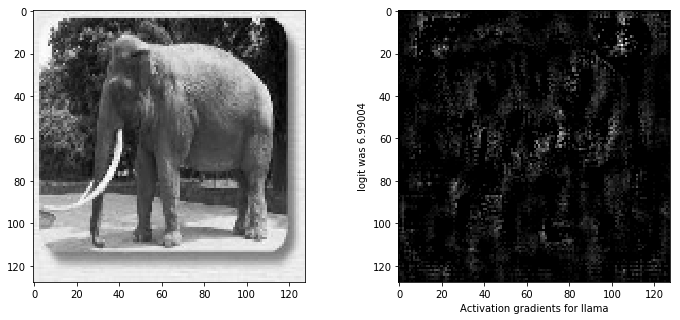

Top matches are: 
llama  -  0.290877
grand_piano  -  0.168546
elephant  -  0.138156
wheelchair  -  0.0984054
lobster  -  0.0871102


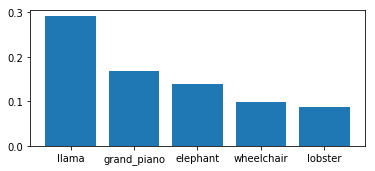

correct class is elephant
--------------------------


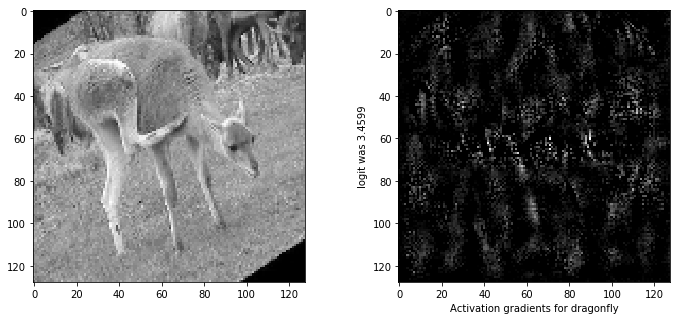

Top matches are: 
dragonfly  -  0.0890787
barrel  -  0.084945
ant  -  0.0748007
Faces  -  0.0632893
lotus  -  0.0583181


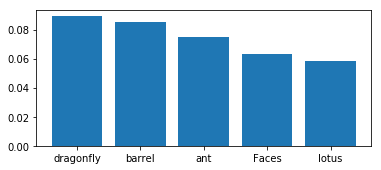

correct class is llama
--------------------------


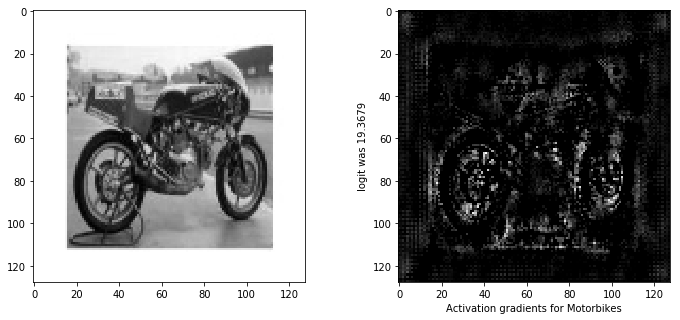

Top matches are: 
Motorbikes  -  0.999971
binocular  -  1.1786e-05
wild_cat  -  3.06284e-06
crab  -  1.99188e-06
stapler  -  1.93326e-06


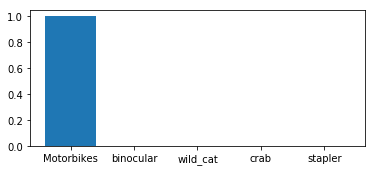

correct class is Motorbikes
--------------------------


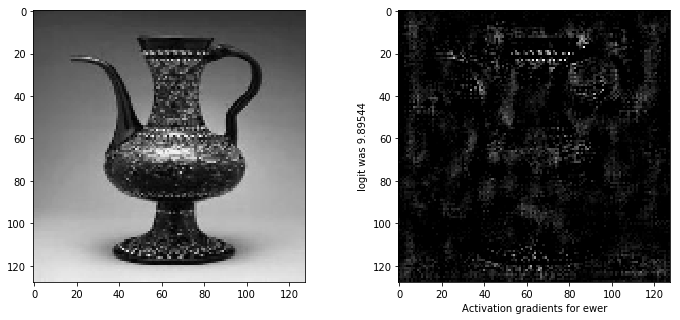

Top matches are: 
ewer  -  0.950245
menorah  -  0.0152438
bonsai  -  0.00638121
nautilus  -  0.0035045
sea_horse  -  0.00254861


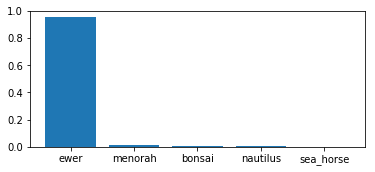

correct class is ewer
--------------------------


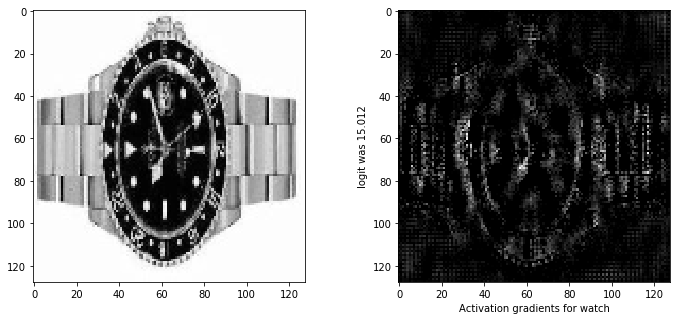

Top matches are: 
watch  -  0.987183
lobster  -  0.00551237
bonsai  -  0.00440473
pizza  -  0.00101112
stegosaurus  -  0.000601906


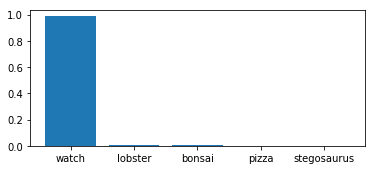

correct class is watch
--------------------------


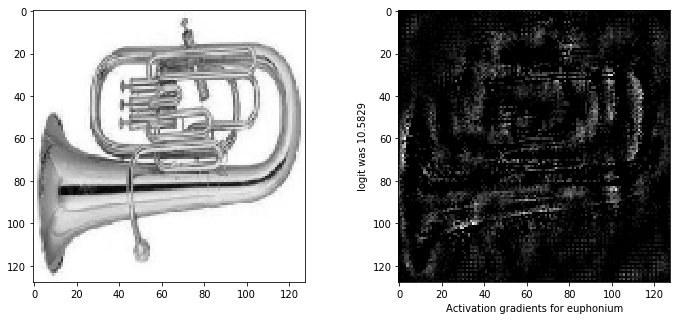

Top matches are: 
euphonium  -  0.973603
electric_guitar  -  0.00476894
octopus  -  0.00371295
watch  -  0.00206958
nautilus  -  0.00181057


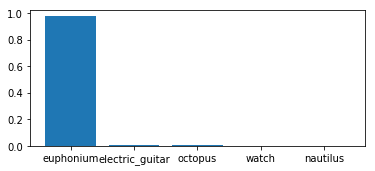

correct class is euphonium
--------------------------


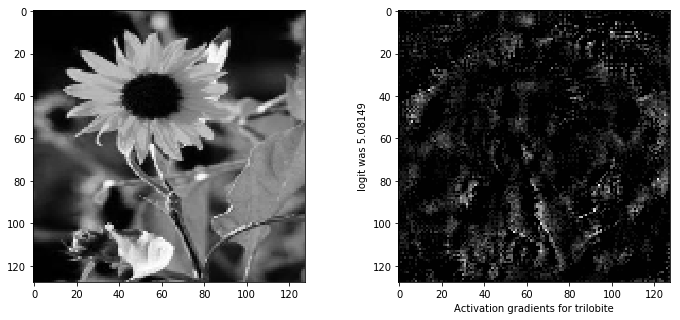

Top matches are: 
trilobite  -  0.20011
sunflower  -  0.183042
sea_horse  -  0.047371
pagoda  -  0.0430948
butterfly  -  0.0405361


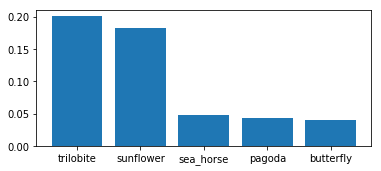

correct class is sunflower
--------------------------


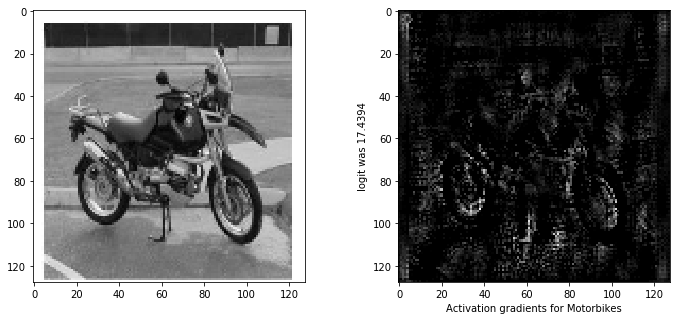

Top matches are: 
Motorbikes  -  0.999809
wheelchair  -  9.15776e-05
chandelier  -  6.16737e-05
chair  -  8.14105e-06
laptop  -  6.13708e-06


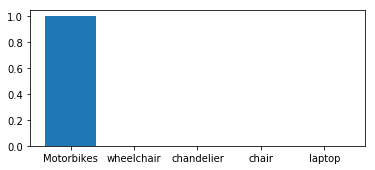

correct class is Motorbikes
--------------------------


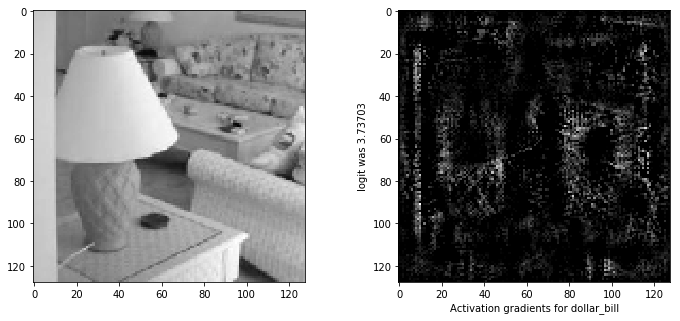

Top matches are: 
dollar_bill  -  0.136794
flamingo  -  0.0574071
kangaroo  -  0.0546278
airplanes  -  0.0417584
starfish  -  0.0382135


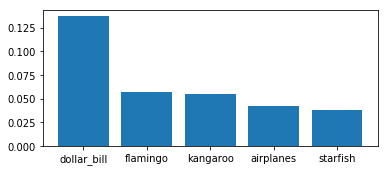

correct class is lamp
--------------------------


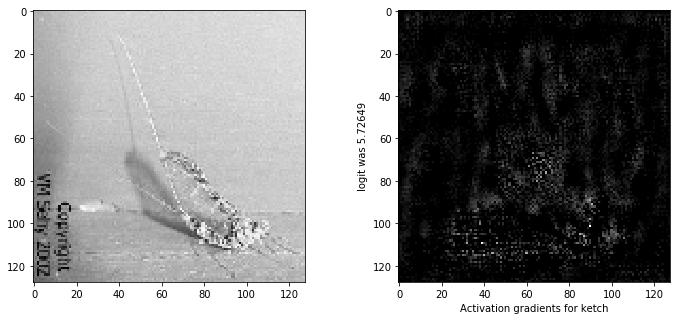

Top matches are: 
ketch  -  0.32232
schooner  -  0.130801
pigeon  -  0.0690098
pyramid  -  0.0639098
starfish  -  0.0522062


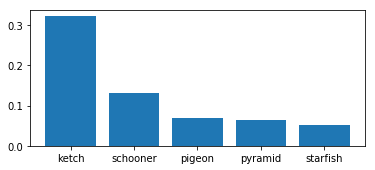

correct class is mayfly
--------------------------


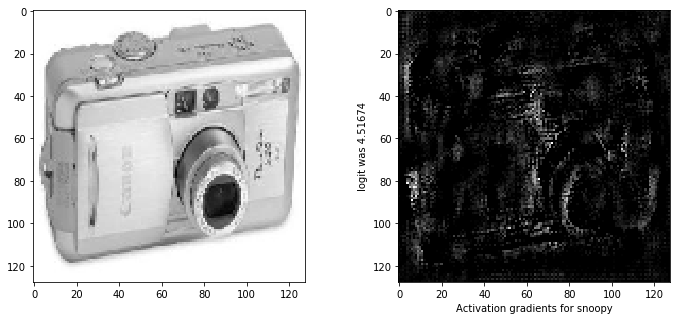

Top matches are: 
snoopy  -  0.158767
camera  -  0.0801999
llama  -  0.0657998
barrel  -  0.0608057
pizza  -  0.0537748


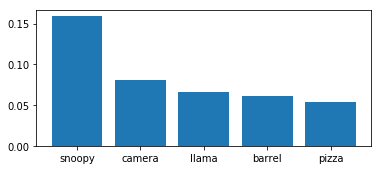

correct class is camera
--------------------------


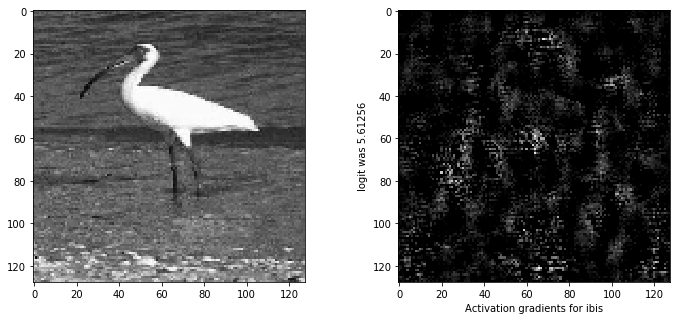

Top matches are: 
ibis  -  0.299283
flamingo  -  0.274669
ewer  -  0.107
dalmatian  -  0.0438911
crocodile  -  0.0305178


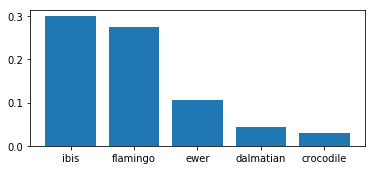

correct class is ibis
--------------------------


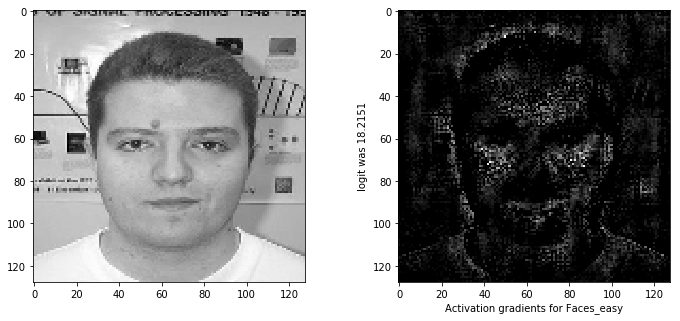

Top matches are: 
Faces_easy  -  0.999985
anchor  -  4.93232e-06
Faces  -  1.871e-06
wrench  -  1.22233e-06
barrel  -  9.62583e-07


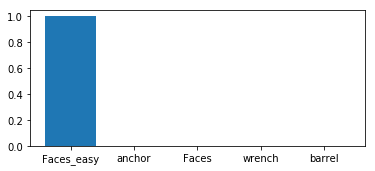

correct class is Faces_easy
--------------------------


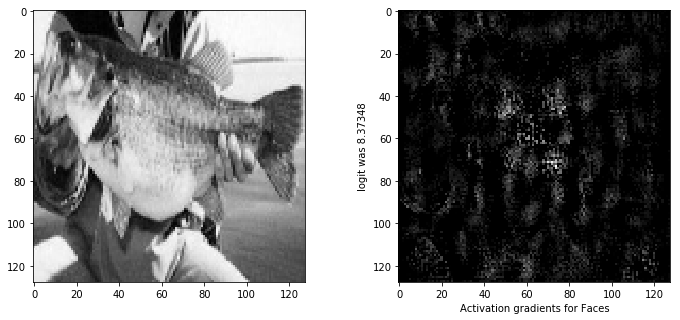

Top matches are: 
Faces  -  0.641616
watch  -  0.0865019
airplanes  -  0.0478689
bass  -  0.0342261
stegosaurus  -  0.0339242


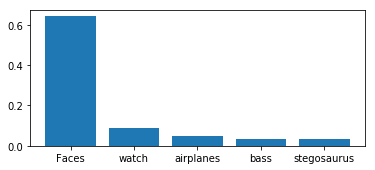

correct class is bass
--------------------------


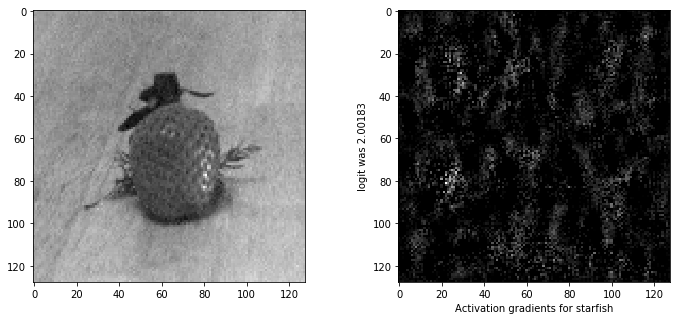

Top matches are: 
starfish  -  0.0450899
crocodile  -  0.034576
beaver  -  0.0331108
scorpion  -  0.0313358
ibis  -  0.0304457


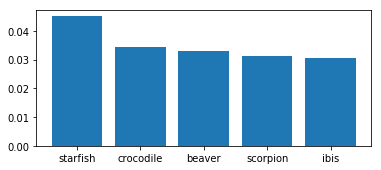

correct class is strawberry
--------------------------


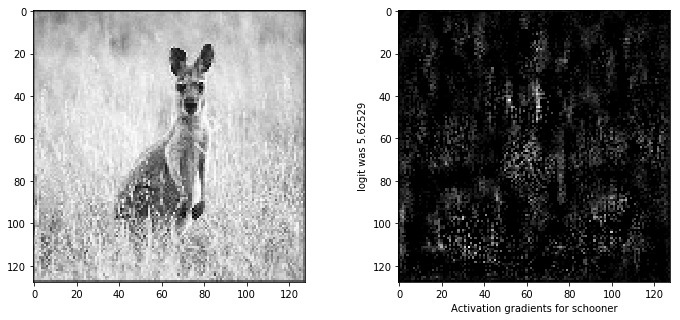

Top matches are: 
schooner  -  0.159081
scissors  -  0.127817
starfish  -  0.124684
chandelier  -  0.0694012
ketch  -  0.0500433


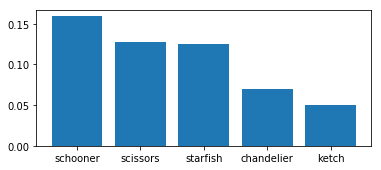

correct class is kangaroo
--------------------------


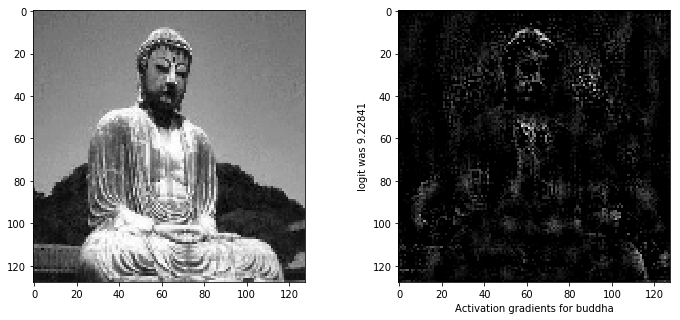

Top matches are: 
buddha  -  0.803378
chandelier  -  0.0438222
joshua_tree  -  0.039652
scissors  -  0.0266342
schooner  -  0.024659


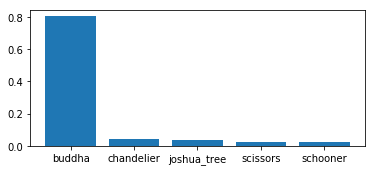

correct class is buddha
--------------------------


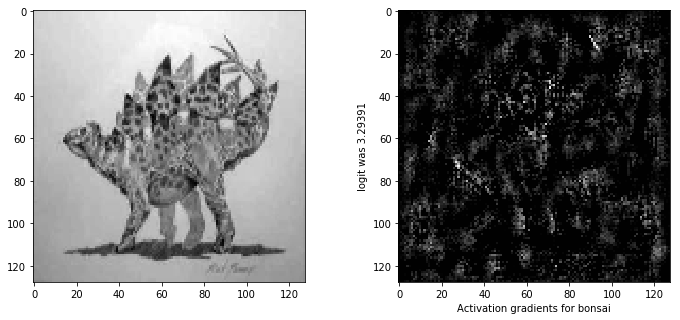

Top matches are: 
bonsai  -  0.101395
ewer  -  0.0783276
starfish  -  0.0500585
ant  -  0.0467232
scorpion  -  0.0391725


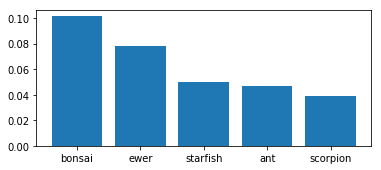

correct class is stegosaurus
--------------------------


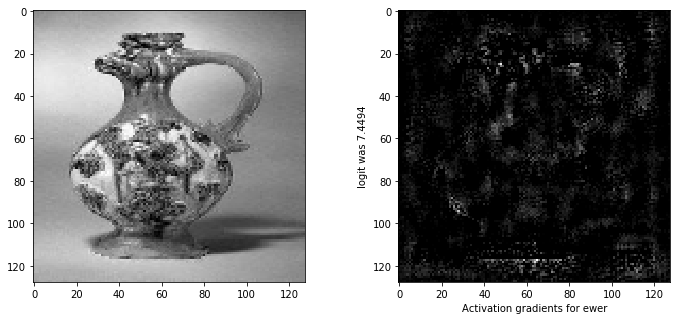

Top matches are: 
ewer  -  0.677821
metronome  -  0.043059
wheelchair  -  0.0311873
dragonfly  -  0.029119
bonsai  -  0.0238182


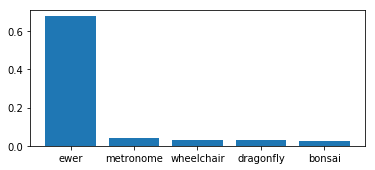

correct class is ewer
--------------------------


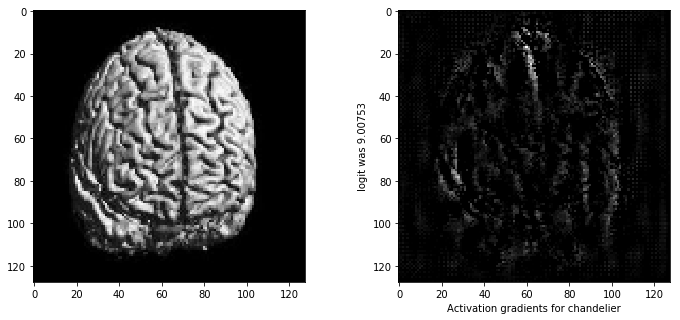

Top matches are: 
chandelier  -  0.630373
brain  -  0.237485
nautilus  -  0.0251453
watch  -  0.0217117
bonsai  -  0.0135368


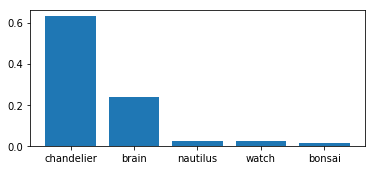

correct class is brain
--------------------------


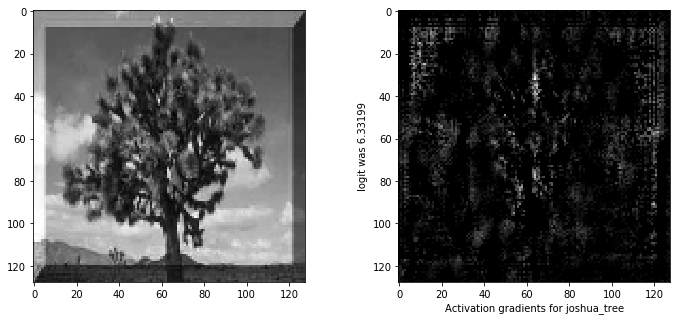

Top matches are: 
joshua_tree  -  0.270281
bonsai  -  0.222013
chandelier  -  0.172808
rooster  -  0.0489286
hedgehog  -  0.0356855


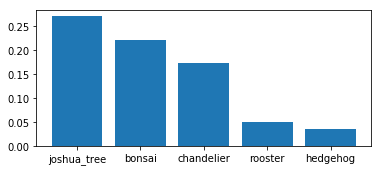

correct class is joshua_tree
--------------------------


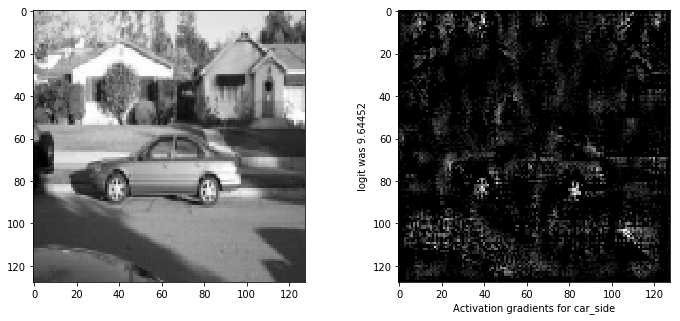

Top matches are: 
car_side  -  0.967717
cannon  -  0.00432892
euphonium  -  0.00413122
crocodile_head  -  0.00294018
crab  -  0.00217042


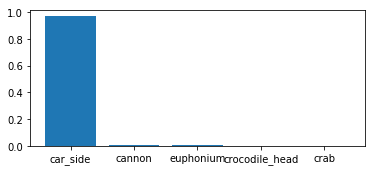

correct class is car_side
--------------------------


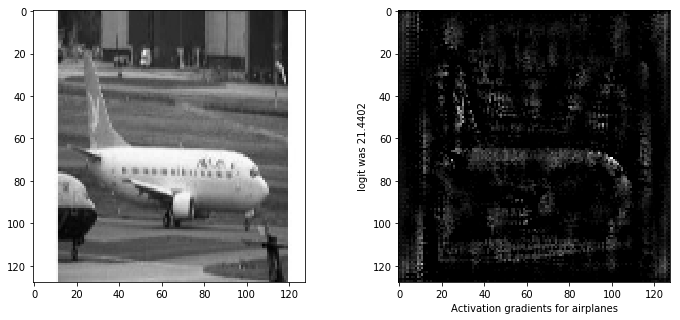

Top matches are: 
airplanes  -  0.999998
Motorbikes  -  1.02076e-06
barrel  -  2.14666e-07
hedgehog  -  8.89046e-08
bass  -  8.45317e-08


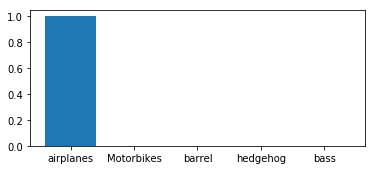

correct class is airplanes
--------------------------


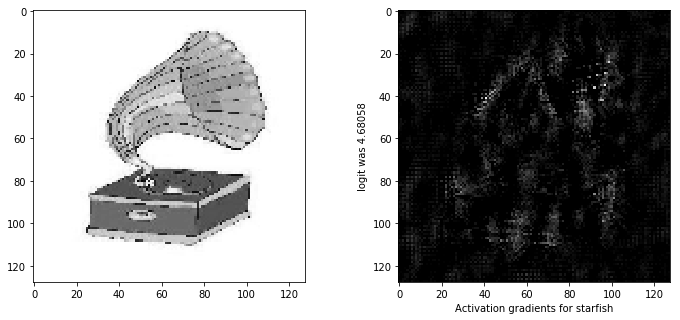

Top matches are: 
starfish  -  0.093447
brain  -  0.0827182
stapler  -  0.0606659
pizza  -  0.0593809
octopus  -  0.0586476


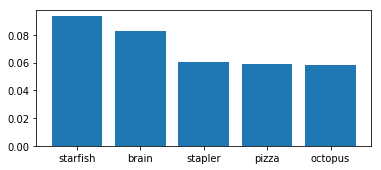

correct class is gramophone
--------------------------


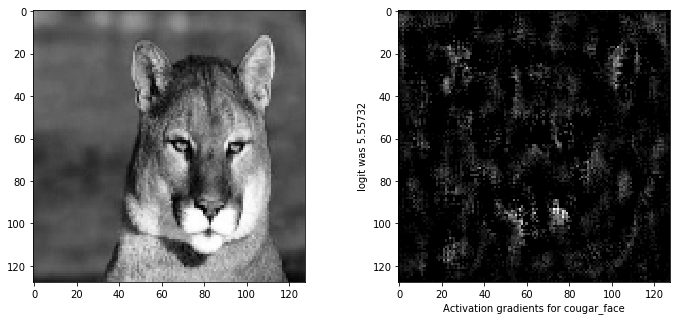

Top matches are: 
cougar_face  -  0.369591
Faces  -  0.175341
ant  -  0.0364453
octopus  -  0.0331941
llama  -  0.0249788


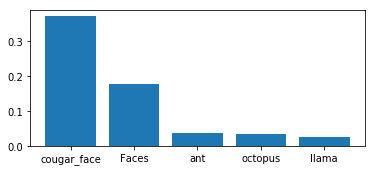

correct class is cougar_face
--------------------------


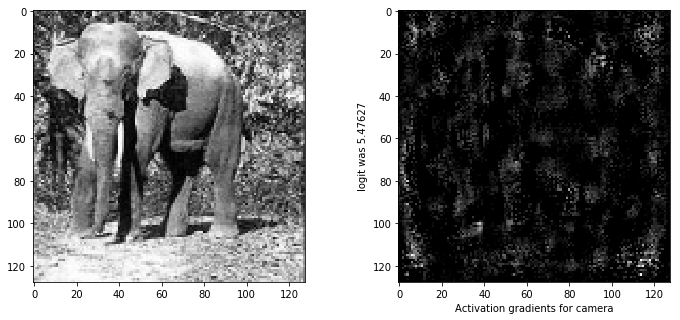

Top matches are: 
camera  -  0.170154
lobster  -  0.12325
llama  -  0.119194
electric_guitar  -  0.108943
wheelchair  -  0.0550665


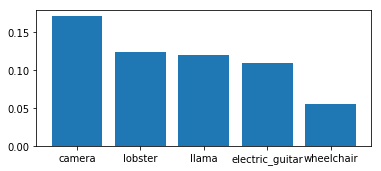

correct class is elephant
--------------------------


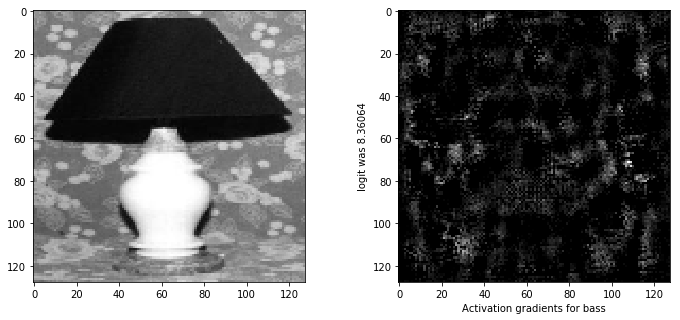

Top matches are: 
bass  -  0.687483
kangaroo  -  0.0605862
Faces  -  0.0596698
Faces_easy  -  0.0560008
binocular  -  0.0371246


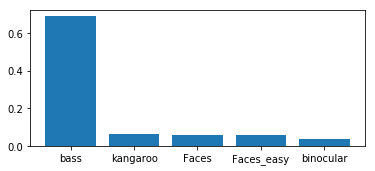

correct class is lamp
--------------------------


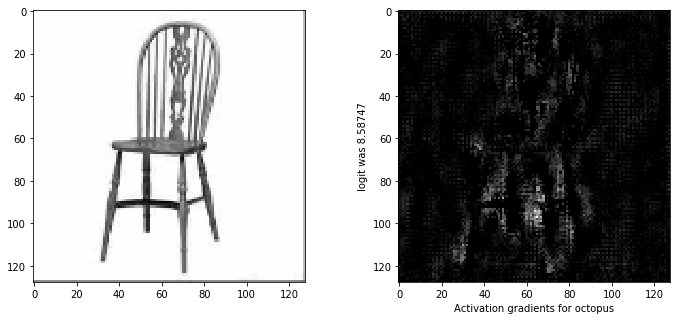

Top matches are: 
octopus  -  0.284754
starfish  -  0.252141
chandelier  -  0.131638
scissors  -  0.109024
dragonfly  -  0.104724


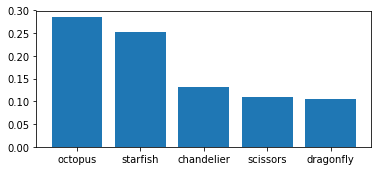

correct class is windsor_chair
--------------------------


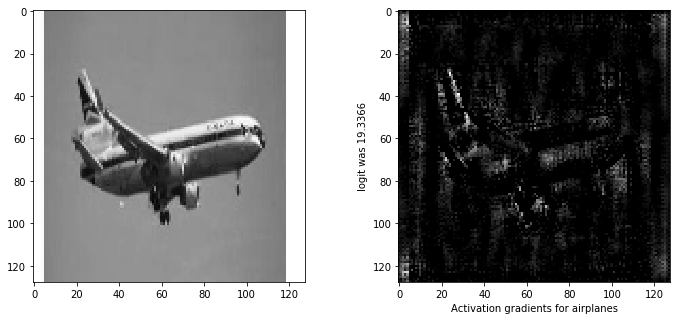

Top matches are: 
airplanes  -  0.999985
Motorbikes  -  6.52588e-06
electric_guitar  -  3.98705e-06
wrench  -  1.36782e-06
mandolin  -  1.30703e-06


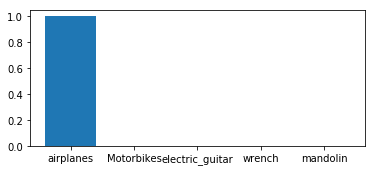

correct class is airplanes
--------------------------


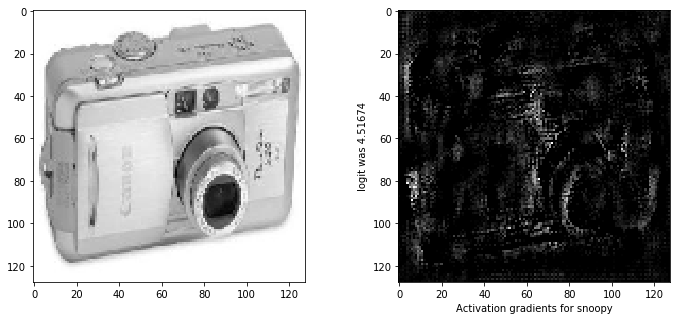

Top matches are: 
snoopy  -  0.158767
camera  -  0.0801999
llama  -  0.0657998
barrel  -  0.0608057
pizza  -  0.0537748


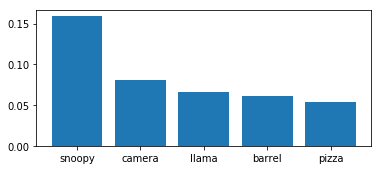

correct class is camera
--------------------------


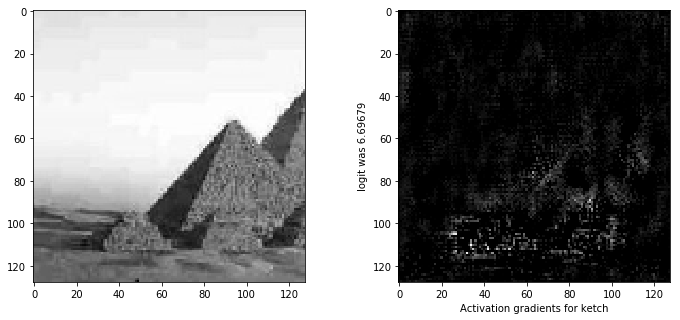

Top matches are: 
ketch  -  0.446167
ferry  -  0.0842011
schooner  -  0.0659916
umbrella  -  0.0540767
ewer  -  0.0366711


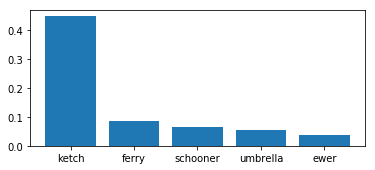

correct class is pyramid
--------------------------


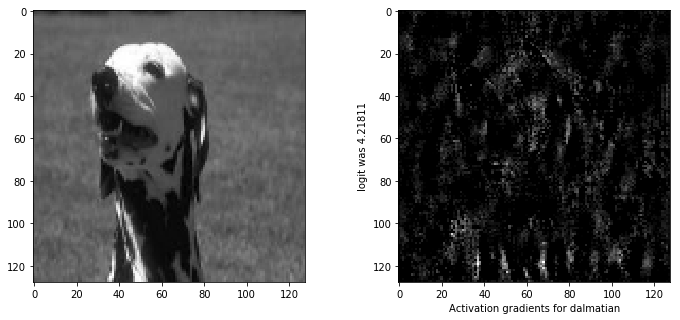

Top matches are: 
dalmatian  -  0.167808
stegosaurus  -  0.0734417
ewer  -  0.0566635
metronome  -  0.0555483
joshua_tree  -  0.0470206


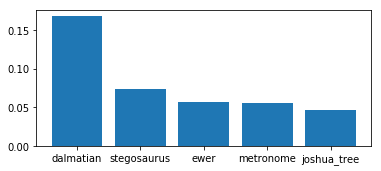

correct class is dalmatian
--------------------------


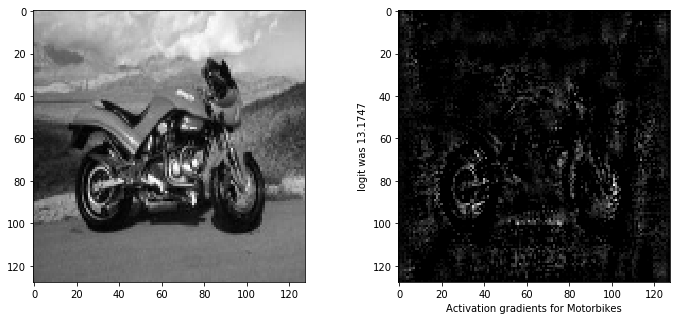

Top matches are: 
Motorbikes  -  0.997154
watch  -  0.000871596
ferry  -  0.000532845
cannon  -  0.00027452
hawksbill  -  0.000227245


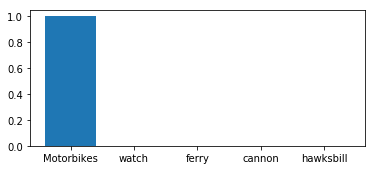

correct class is Motorbikes
--------------------------


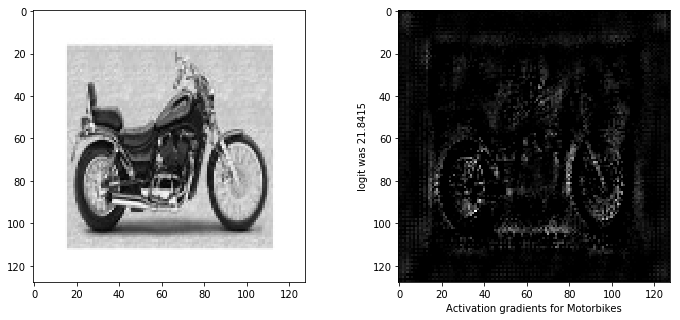

Top matches are: 
Motorbikes  -  0.999999
stapler  -  2.88407e-07
crayfish  -  1.65805e-07
wheelchair  -  8.52411e-08
tick  -  5.82877e-08


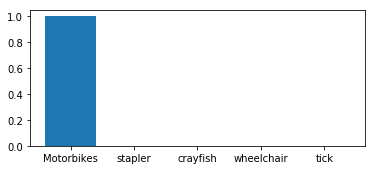

correct class is Motorbikes
--------------------------


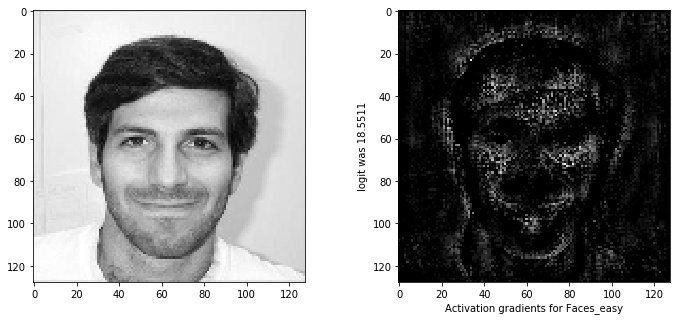

Top matches are: 
Faces_easy  -  0.999976
ewer  -  6.22771e-06
barrel  -  3.62129e-06
Faces  -  2.61889e-06
rooster  -  1.57658e-06


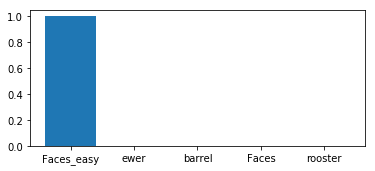

correct class is Faces_easy
--------------------------


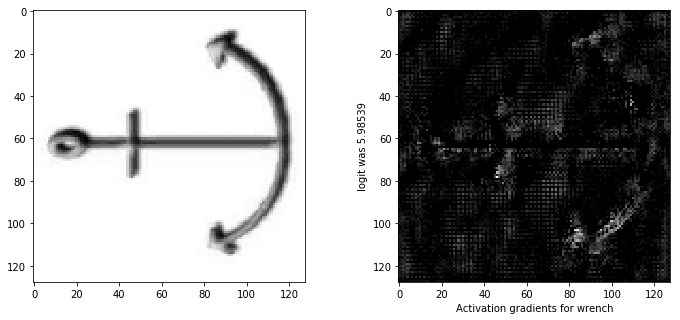

Top matches are: 
wrench  -  0.241966
anchor  -  0.209134
electric_guitar  -  0.11715
mandolin  -  0.0909404
nautilus  -  0.0527665


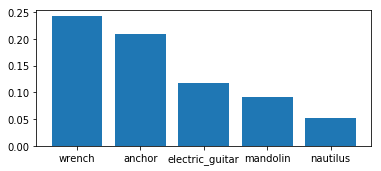

correct class is anchor
--------------------------


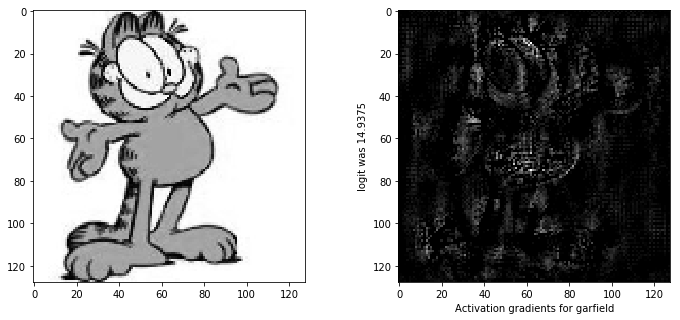

Top matches are: 
garfield  -  0.996967
bonsai  -  0.000977069
ewer  -  0.000645425
rooster  -  0.00026912
stegosaurus  -  0.000129281


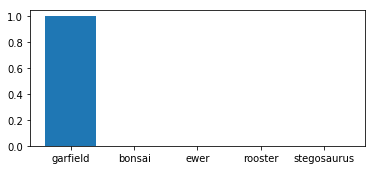

correct class is garfield
--------------------------


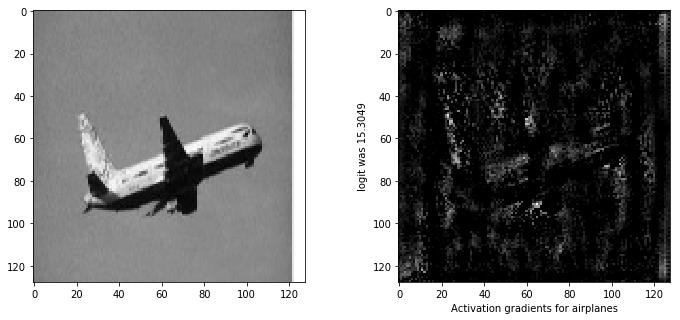

Top matches are: 
airplanes  -  0.999624
chandelier  -  0.000115114
electric_guitar  -  4.76953e-05
mandolin  -  2.88169e-05
Motorbikes  -  2.77719e-05


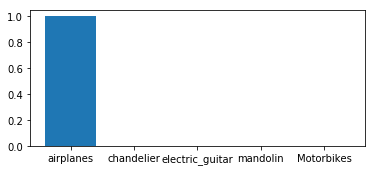

correct class is airplanes
--------------------------


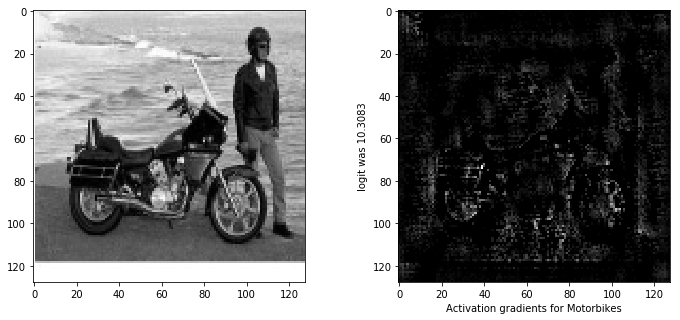

Top matches are: 
Motorbikes  -  0.962753
revolver  -  0.00574535
cup  -  0.00497119
cannon  -  0.00429492
hawksbill  -  0.00305121


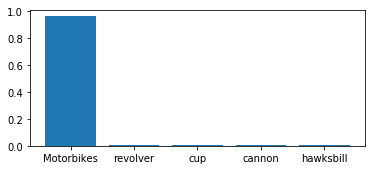

correct class is Motorbikes
--------------------------


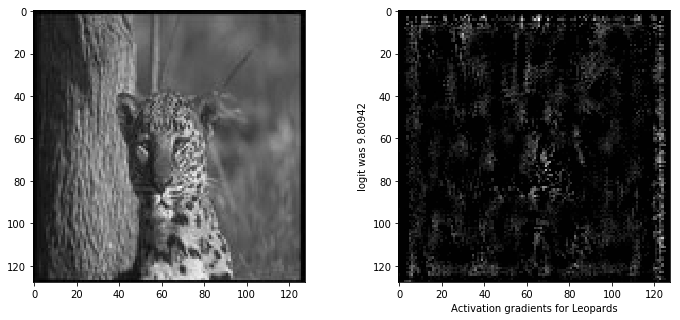

Top matches are: 
Leopards  -  0.987142
cougar_face  -  0.00101819
sea_horse  -  0.000681912
ibis  -  0.000629521
ant  -  0.000597994


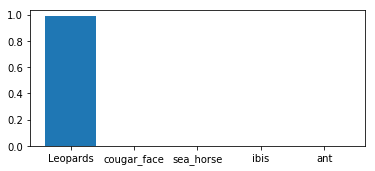

correct class is Leopards
--------------------------


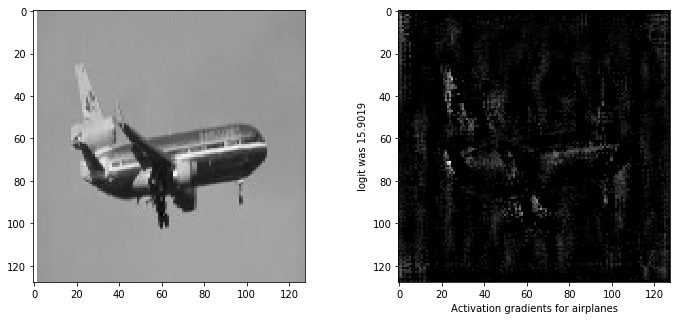

Top matches are: 
airplanes  -  0.999865
helicopter  -  2.8442e-05
Motorbikes  -  2.0891e-05
mayfly  -  1.17336e-05
stapler  -  9.41855e-06


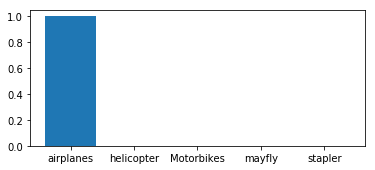

correct class is airplanes
--------------------------


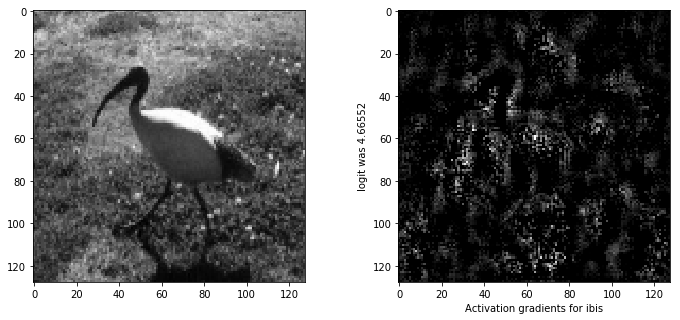

Top matches are: 
ibis  -  0.303016
llama  -  0.163254
flamingo  -  0.0648352
bonsai  -  0.0258848
emu  -  0.0249753


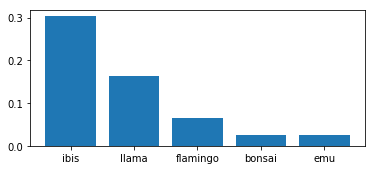

correct class is ibis
--------------------------


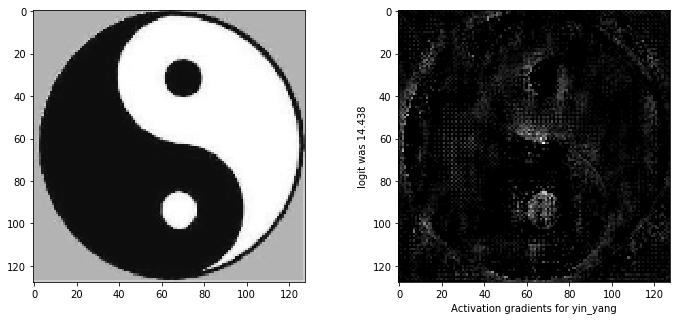

Top matches are: 
yin_yang  -  0.996837
ewer  -  0.00152755
soccer_ball  -  0.000811533
panda  -  0.000303306
saxophone  -  6.91769e-05


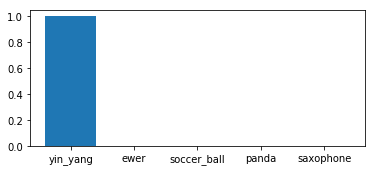

correct class is yin_yang
--------------------------


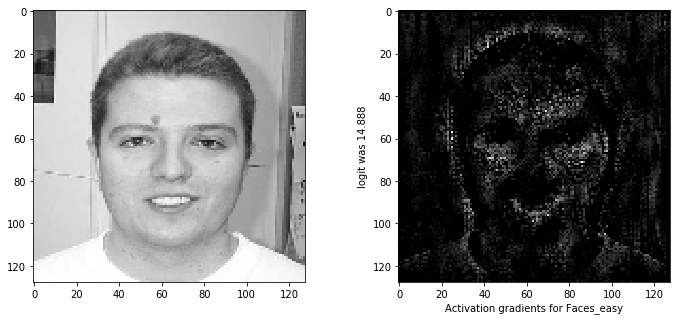

Top matches are: 
Faces_easy  -  0.999514
Faces  -  0.000352289
barrel  -  1.36133e-05
cougar_face  -  1.24145e-05
menorah  -  1.18809e-05


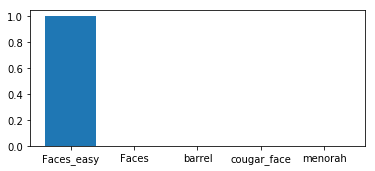

correct class is Faces_easy
--------------------------


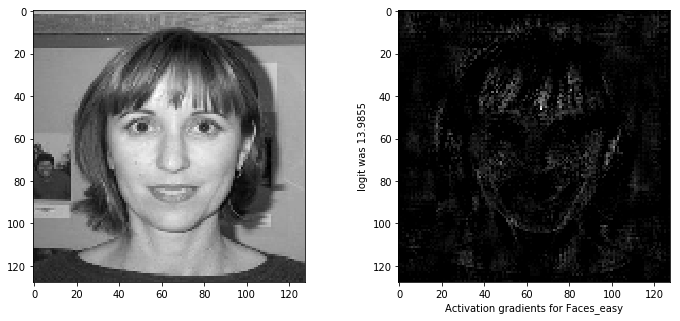

Top matches are: 
Faces_easy  -  0.999369
Faces  -  0.000146158
dalmatian  -  0.000127274
lotus  -  6.26408e-05
bass  -  4.22074e-05


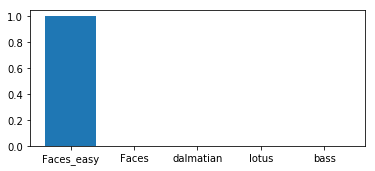

correct class is Faces_easy
--------------------------


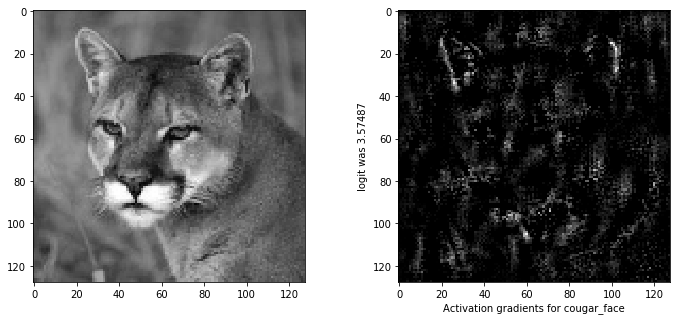

Top matches are: 
cougar_face  -  0.133161
ant  -  0.0714819
emu  -  0.0688447
Faces  -  0.0416458
octopus  -  0.0404748


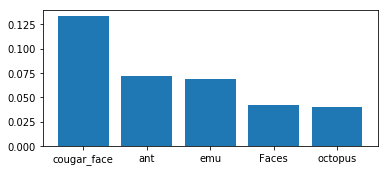

correct class is cougar_face
--------------------------


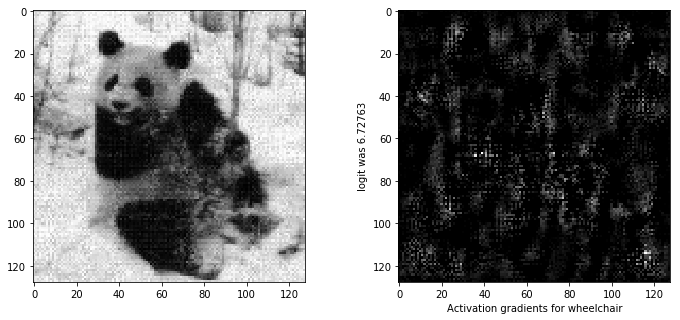

Top matches are: 
wheelchair  -  0.351575
bonsai  -  0.136236
metronome  -  0.109069
barrel  -  0.0740685
laptop  -  0.0385923


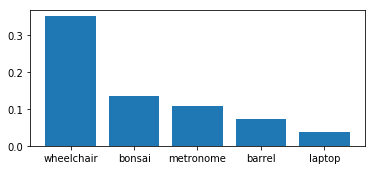

correct class is panda
--------------------------


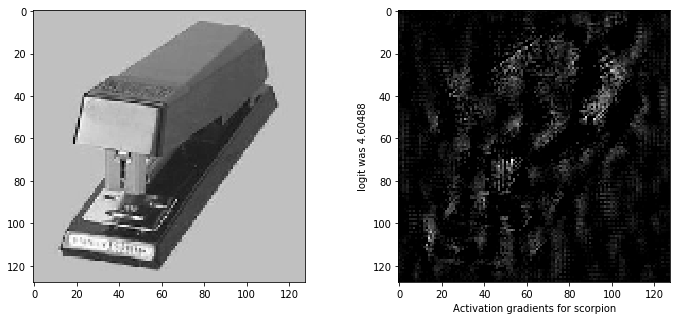

Top matches are: 
scorpion  -  0.118354
stapler  -  0.110927
rooster  -  0.0733447
cougar_face  -  0.0732039
pigeon  -  0.0674455


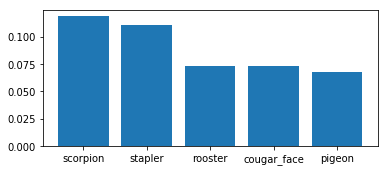

correct class is stapler
--------------------------


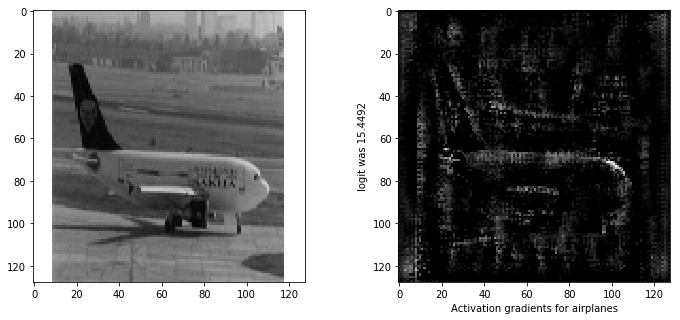

Top matches are: 
airplanes  -  0.99904
Motorbikes  -  0.000713728
stapler  -  3.06536e-05
camera  -  2.97113e-05
electric_guitar  -  2.20289e-05


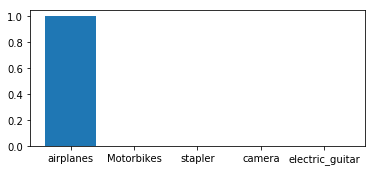

correct class is airplanes
--------------------------


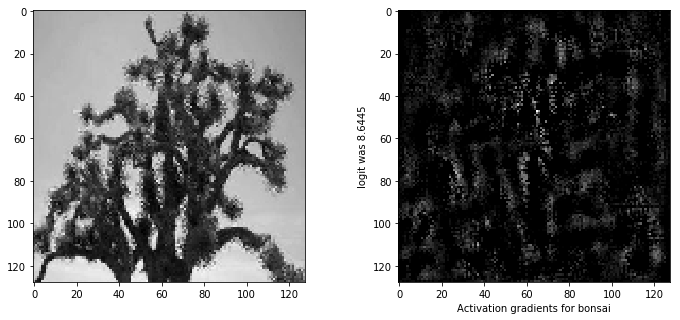

Top matches are: 
bonsai  -  0.786251
joshua_tree  -  0.0417996
cup  -  0.0173505
llama  -  0.017081
hedgehog  -  0.0160939


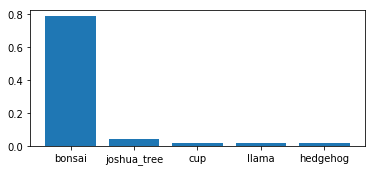

correct class is joshua_tree
--------------------------


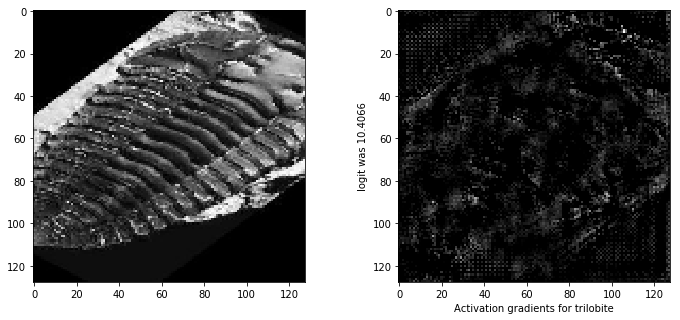

Top matches are: 
trilobite  -  0.949405
pagoda  -  0.0140361
bonsai  -  0.0118705
cellphone  -  0.00732729
crab  -  0.00446585


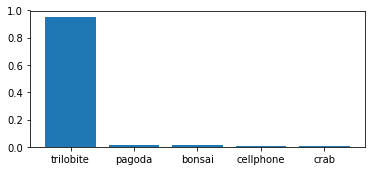

correct class is trilobite
--------------------------


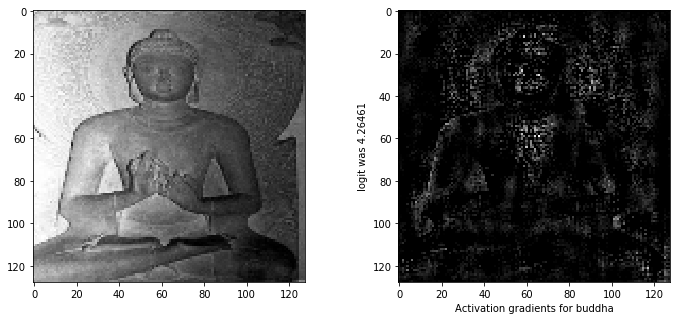

Top matches are: 
buddha  -  0.216308
bonsai  -  0.0814946
nautilus  -  0.0435484
scissors  -  0.0420007
beaver  -  0.0371833


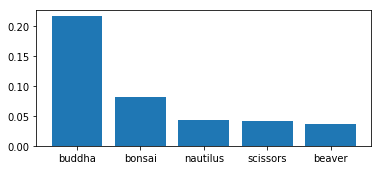

correct class is buddha
--------------------------


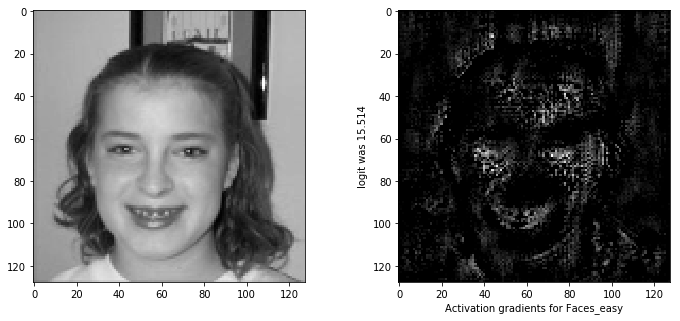

Top matches are: 
Faces_easy  -  0.999781
Faces  -  8.84814e-05
cougar_body  -  4.22286e-05
binocular  -  2.36721e-05
garfield  -  7.3259e-06


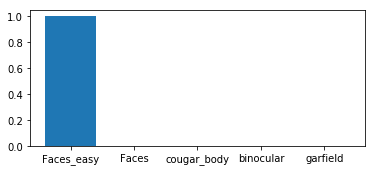

correct class is Faces_easy
--------------------------


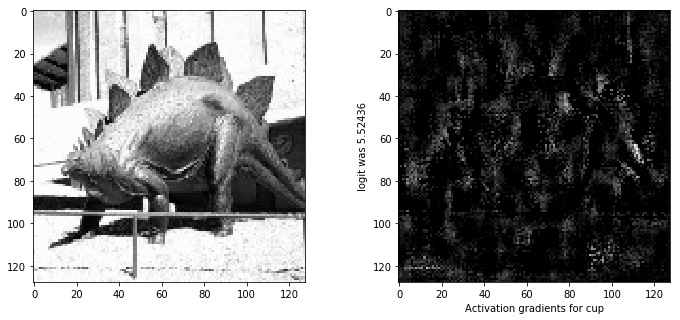

Top matches are: 
cup  -  0.113367
stapler  -  0.100702
llama  -  0.0916066
watch  -  0.0903344
stegosaurus  -  0.0902114


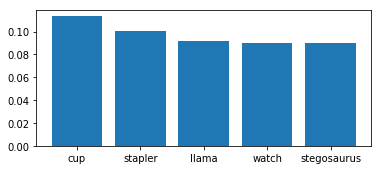

correct class is stegosaurus
--------------------------


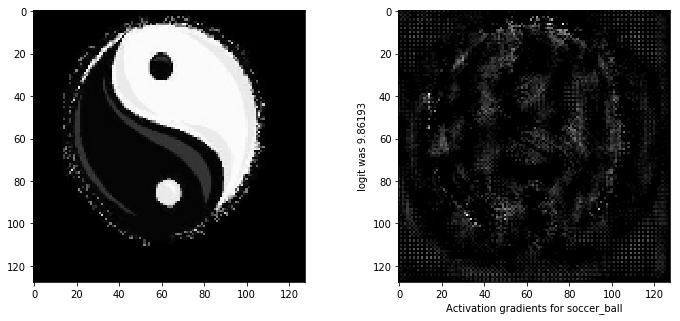

Top matches are: 
soccer_ball  -  0.786801
yin_yang  -  0.136119
lamp  -  0.0227786
brain  -  0.0153353
lotus  -  0.00563913


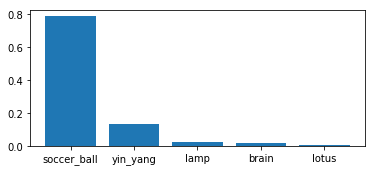

correct class is yin_yang
--------------------------


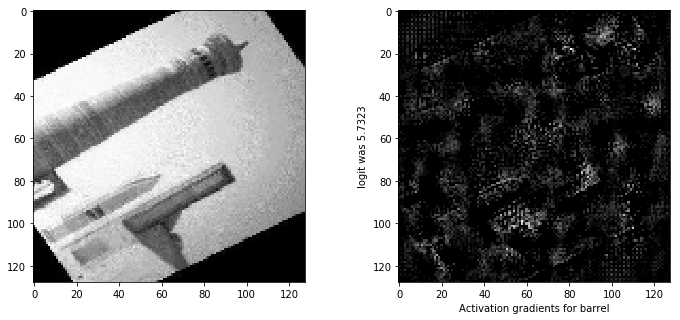

Top matches are: 
barrel  -  0.253235
minaret  -  0.199269
pagoda  -  0.111303
garfield  -  0.0663588
ewer  -  0.0373759


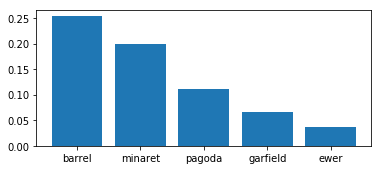

correct class is minaret
--------------------------


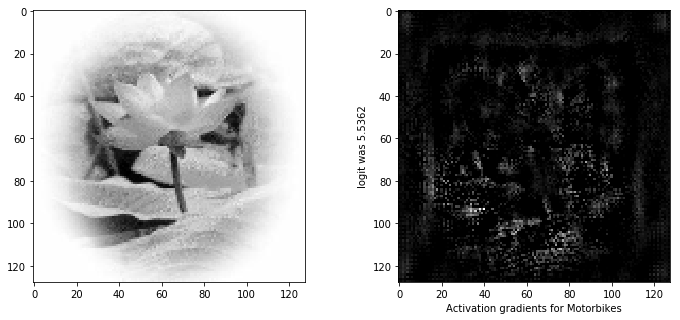

Top matches are: 
Motorbikes  -  0.200884
stapler  -  0.155631
rooster  -  0.0722588
ant  -  0.060928
umbrella  -  0.0530694


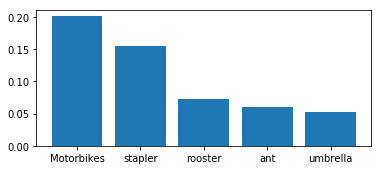

correct class is lotus
--------------------------


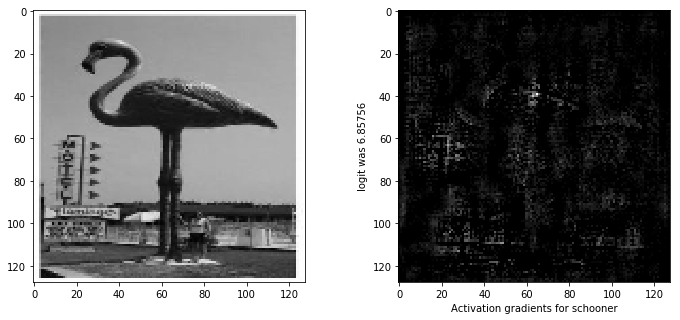

Top matches are: 
schooner  -  0.262101
bonsai  -  0.232156
ketch  -  0.124919
hedgehog  -  0.0820037
joshua_tree  -  0.0707395


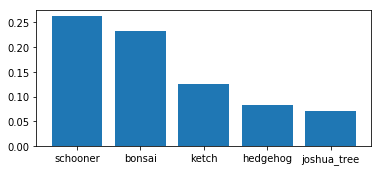

correct class is flamingo
--------------------------


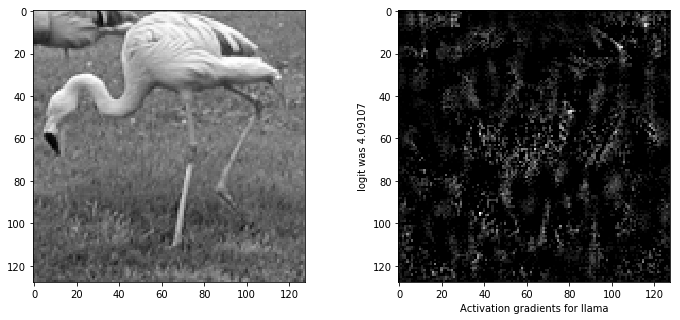

Top matches are: 
llama  -  0.155748
flamingo  -  0.127787
umbrella  -  0.106978
barrel  -  0.0503489
kangaroo  -  0.0477188


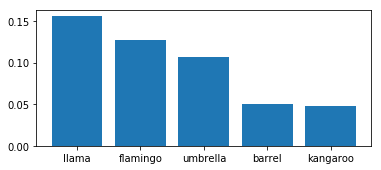

correct class is flamingo
--------------------------


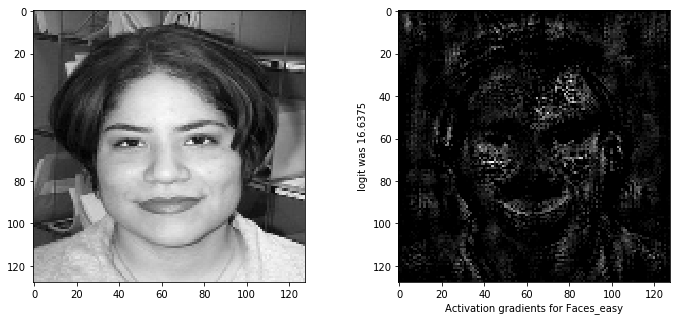

Top matches are: 
Faces_easy  -  0.999965
cup  -  6.02761e-06
crocodile_head  -  6.02478e-06
anchor  -  5.56633e-06
Faces  -  3.00387e-06


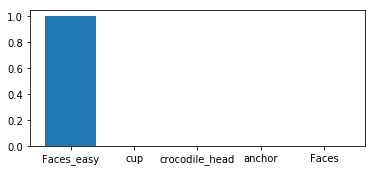

correct class is Faces_easy
--------------------------


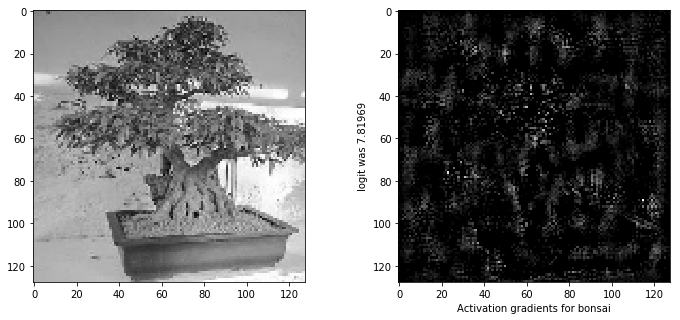

Top matches are: 
bonsai  -  0.844493
pizza  -  0.0190971
ewer  -  0.0147947
lobster  -  0.0120273
nautilus  -  0.010182


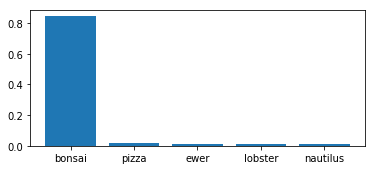

correct class is bonsai
--------------------------


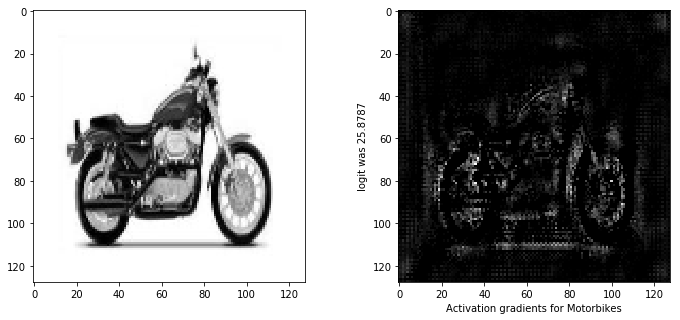

Top matches are: 
Motorbikes  -  1.0
wheelchair  -  2.91632e-08
chair  -  3.58323e-09
inline_skate  -  3.431e-09
ant  -  2.98153e-09


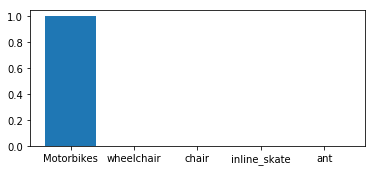

correct class is Motorbikes
--------------------------


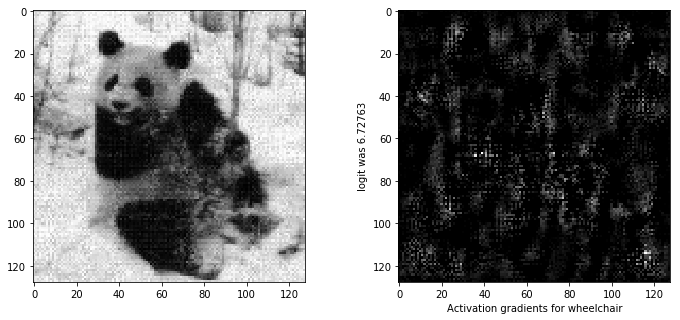

Top matches are: 
wheelchair  -  0.351575
bonsai  -  0.136236
metronome  -  0.109069
barrel  -  0.0740685
laptop  -  0.0385923


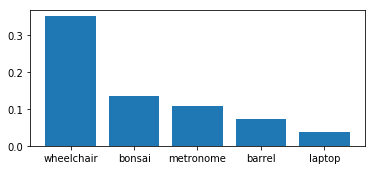

correct class is panda
--------------------------


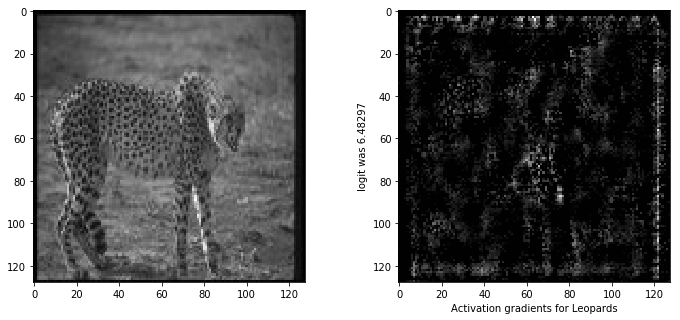

Top matches are: 
Leopards  -  0.756669
crocodile  -  0.0245684
hedgehog  -  0.0215011
crayfish  -  0.014888
crocodile_head  -  0.0136365


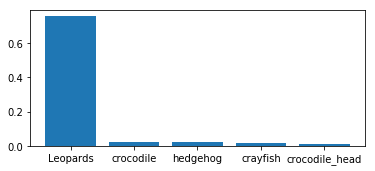

correct class is Leopards
--------------------------


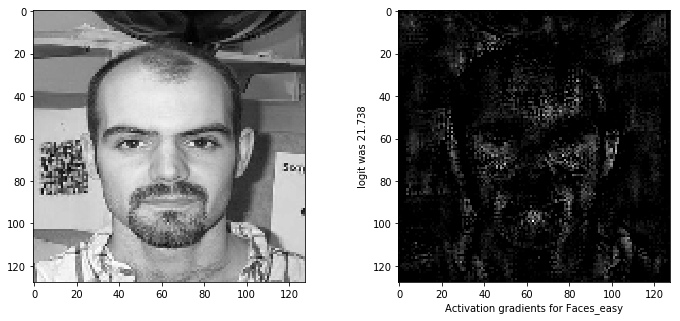

Top matches are: 
Faces_easy  -  1.0
dalmatian  -  6.27535e-08
Faces  -  4.66077e-08
wrench  -  4.10823e-08
water_lilly  -  3.50678e-08


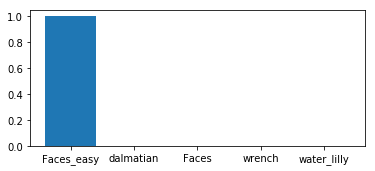

correct class is Faces_easy
--------------------------


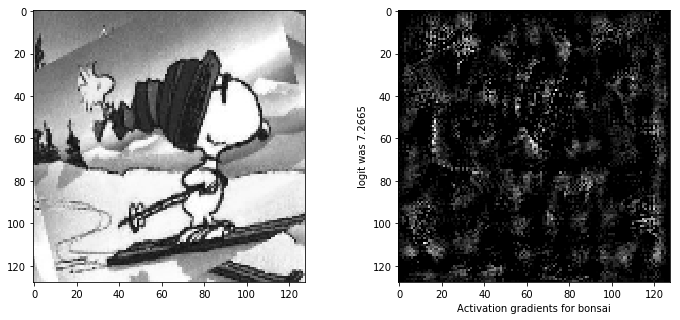

Top matches are: 
bonsai  -  0.460761
wheelchair  -  0.0671955
schooner  -  0.0659419
dalmatian  -  0.0624527
ewer  -  0.0387523


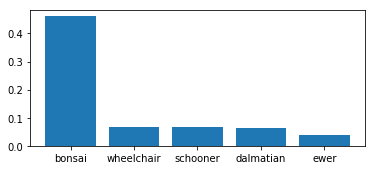

correct class is snoopy
--------------------------


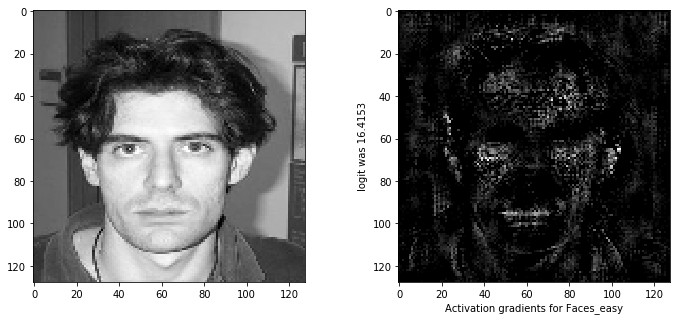

Top matches are: 
Faces_easy  -  0.999787
Faces  -  0.000148804
dalmatian  -  2.2576e-05
bass  -  1.17432e-05
anchor  -  3.83105e-06


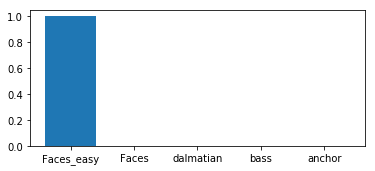

correct class is Faces_easy
--------------------------


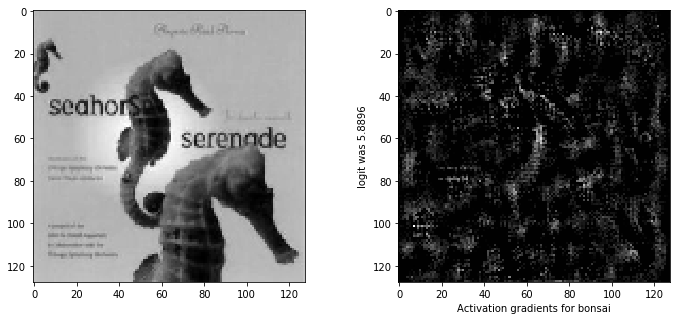

Top matches are: 
bonsai  -  0.37744
Faces  -  0.0831135
dalmatian  -  0.0785258
schooner  -  0.0682983
chandelier  -  0.0618354


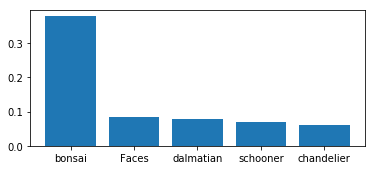

correct class is sea_horse
--------------------------


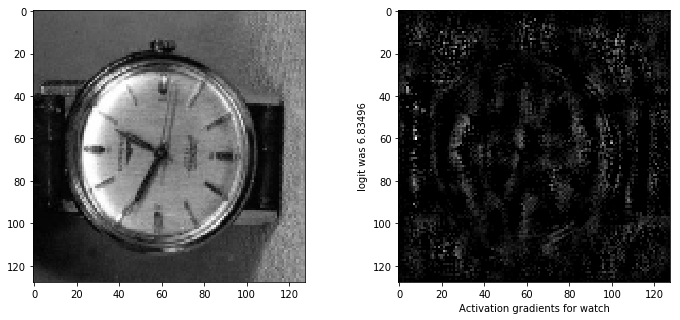

Top matches are: 
watch  -  0.56984
pizza  -  0.0770554
soccer_ball  -  0.0611825
euphonium  -  0.046365
bass  -  0.0336938


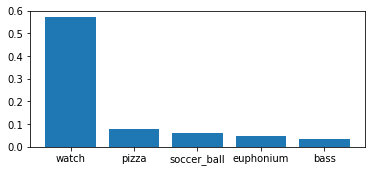

correct class is watch
--------------------------


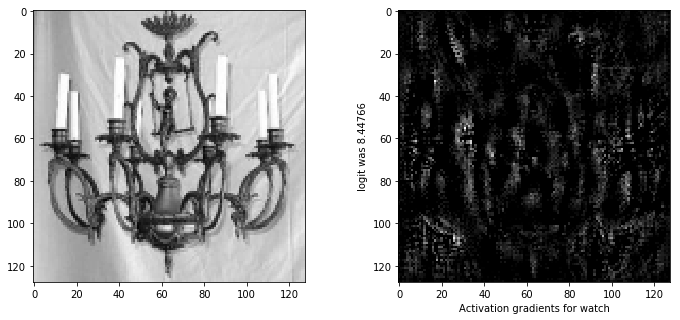

Top matches are: 
watch  -  0.622934
pizza  -  0.132724
chandelier  -  0.0830875
Faces  -  0.031041
octopus  -  0.0254921


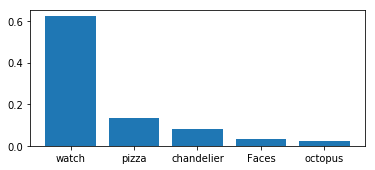

correct class is chandelier
--------------------------


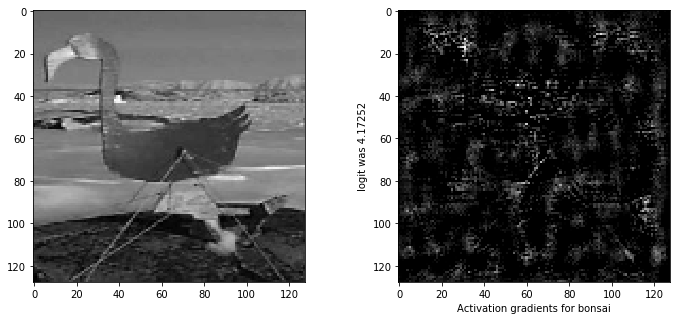

Top matches are: 
bonsai  -  0.216351
ketch  -  0.0924269
ibis  -  0.0858315
emu  -  0.0564768
chair  -  0.0381389


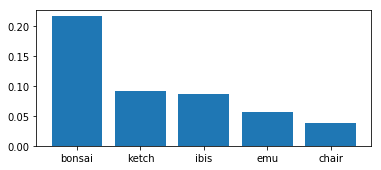

correct class is flamingo
--------------------------


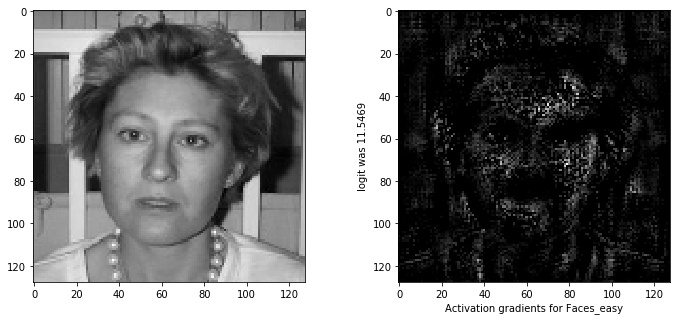

Top matches are: 
Faces_easy  -  0.993533
Faces  -  0.00192151
anchor  -  0.000794133
barrel  -  0.000537576
pizza  -  0.000506805


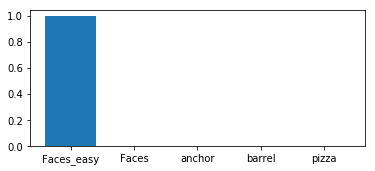

correct class is Faces_easy
--------------------------


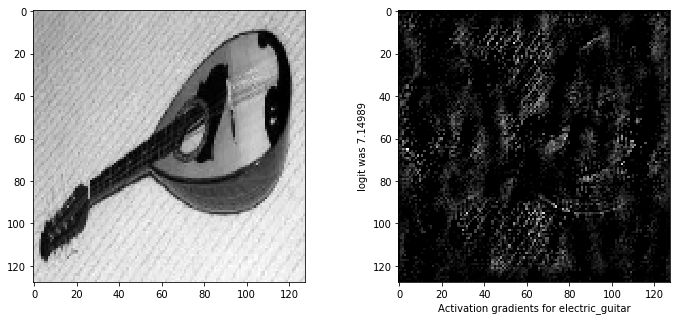

Top matches are: 
electric_guitar  -  0.252606
crab  -  0.23012
rhino  -  0.21365
Motorbikes  -  0.0354836
euphonium  -  0.0335713


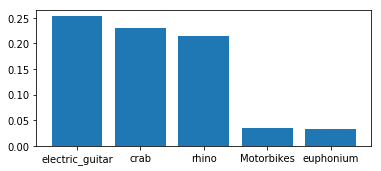

correct class is mandolin
--------------------------


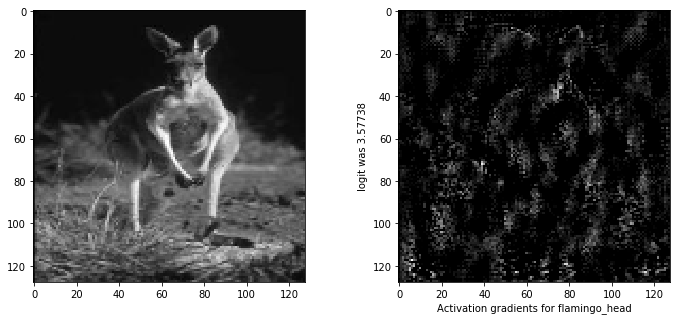

Top matches are: 
flamingo_head  -  0.146204
bonsai  -  0.0763592
kangaroo  -  0.0664448
dragonfly  -  0.0487649
hawksbill  -  0.0409379


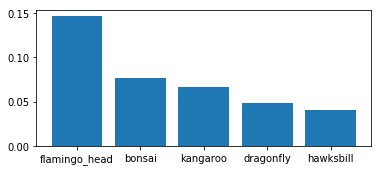

correct class is kangaroo
--------------------------


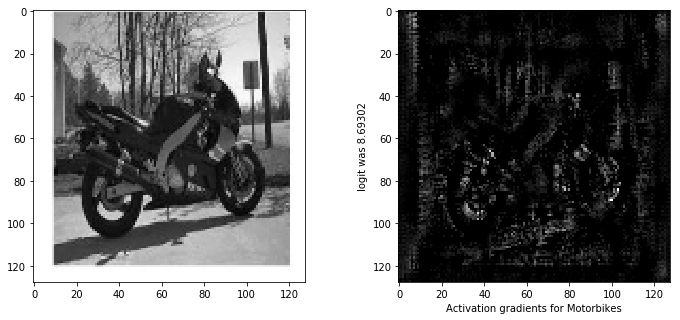

Top matches are: 
Motorbikes  -  0.597645
camera  -  0.222053
lobster  -  0.0240573
pizza  -  0.0182373
cup  -  0.0156141


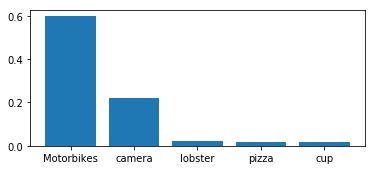

correct class is Motorbikes
--------------------------


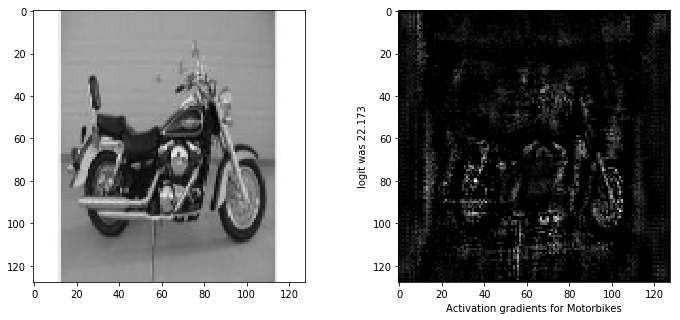

Top matches are: 
Motorbikes  -  0.987217
airplanes  -  0.0127822
crayfish  -  1.22243e-07
stapler  -  9.10856e-08
chandelier  -  7.74786e-08


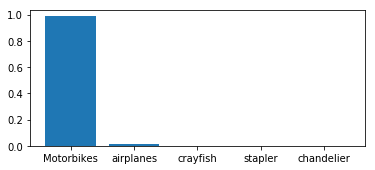

correct class is Motorbikes
--------------------------


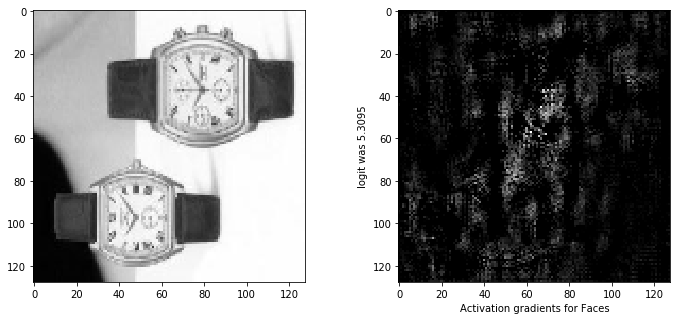

Top matches are: 
Faces  -  0.220564
water_lilly  -  0.169868
dalmatian  -  0.0695504
llama  -  0.0641365
cougar_face  -  0.0474777


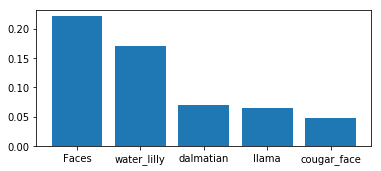

correct class is watch
--------------------------


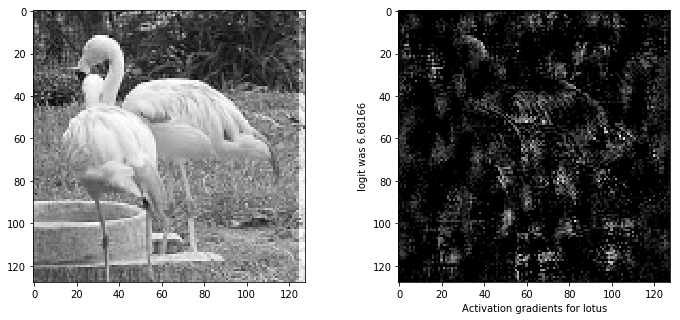

Top matches are: 
lotus  -  0.511435
flamingo  -  0.124566
ibis  -  0.0780307
water_lilly  -  0.0546579
nautilus  -  0.0231466


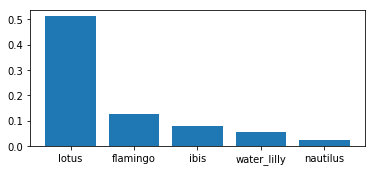

correct class is flamingo
--------------------------


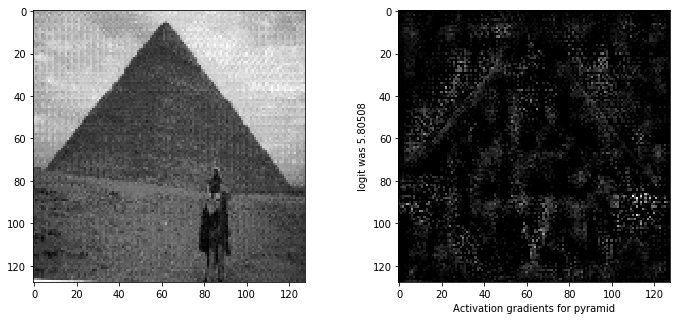

Top matches are: 
pyramid  -  0.335086
stegosaurus  -  0.213034
bonsai  -  0.117204
llama  -  0.0612357
sunflower  -  0.0521246


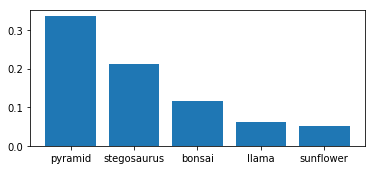

correct class is pyramid
--------------------------


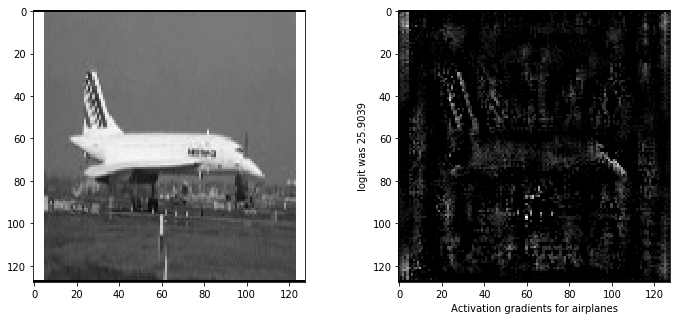

Top matches are: 
airplanes  -  1.0
electric_guitar  -  8.89455e-08
Motorbikes  -  6.6096e-09
chandelier  -  5.13887e-09
mayfly  -  8.71425e-10


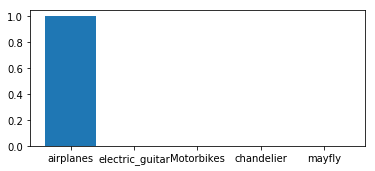

correct class is airplanes
--------------------------


In [132]:
for i in range(100):
    image1=test_batch_features[i]
    pretty_out(image1)
    print("correct class is "+str(categories[test_batch_labels[i]]))
    print("--------------------------")

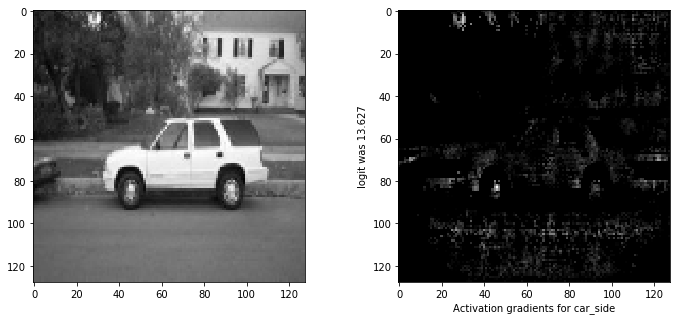

Top matches are: 
car_side  -  0.997989
airplanes  -  0.00109983
gramophone  -  0.0001988
Motorbikes  -  0.000182872
wheelchair  -  7.62456e-05


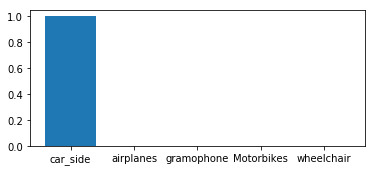

correct class is car_side


In [20]:
ii+=1
image1=X_test[ii]
pretty_out(image1)
print("correct class is "+str(categories[y_test[ii]]))


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Transformed


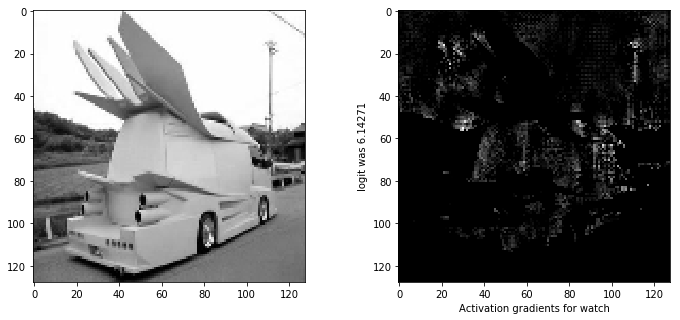

Top matches are: 
watch  -  0.219377
electric_guitar  -  0.122383
garfield  -  0.0981821
sunflower  -  0.0777929
ketch  -  0.0588872


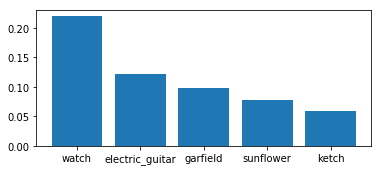

In [21]:
name="vic40.png"
image1=plt.imread("/Users/MattHarrison/"+name)
#pretty_out(image1)
pretty_out(image1)
